In [178]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import itertools

In [398]:
flex_dir = "dynamic/"
minimal_dir = "min/20211221/6/"
maximal_dir = "max/"

In [180]:
learning_steps = 1024000 * 2
n_steps_value = 2048 * 8
number_of_rollouts = learning_steps / n_steps_value

In [181]:
def string_to_list(string):
    string = string[1:-1]
    string = string.replace(" ", "")
    res = string.split(",")
    return [float(x) for x in res]    

def string_to_list_of_lists(string):
    res = []
    string = string[1:-1]
    string = string.replace(" ", "")
    outer_list = string.split("],")
    for inner_list in outer_list:
        tmp_str = inner_list+"]"
        res.append(tmp_str)
    res[-1] = res[-1][:-1]
    return [_list.strip("[]").split(",") for _list in res]

def combine_lists(attribute_list, folder_name):
    res = []
    for file in attribute_list:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list(data))
    return res

def combine_lists_distribution(list_of_text_files, folder_name):
    res = []
    for file in list_of_text_files:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list_of_lists(data))
    return res

def mean_min_max(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in zip(*list_of_lists):
        _min.append(min(elements))
        _max.append(max(elements))
        _mean.append(sum(elements)/len(elements))
    return _mean, _min, _max  

def mean_min_max_distribution(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in itertools.zip_longest(*list_of_lists, fillvalue=0):
        float_elements = [float(x) for x in elements]
        _min.append(min(float_elements))
        _max.append(max(float_elements))
        _mean.append(sum(float_elements)/len(float_elements))
    return _mean, _min, _max

In [182]:
def plot_in_between(mean_min_max_list):
    _x = list(range(len(mean_min_max_list[0])))
    _y_mean = mean_min_max_list[0]
    _y_min = mean_min_max_list[1]
    _y_max = mean_min_max_list[2]
    plt.plot(_x, _y_mean)
    plt.fill_between(_x, _y_min, _y_max, alpha=0.3)
    plt.show()

def plot_by_metric(metric):
    metric_list_flex = [path for path in os.listdir(flex_dir) if metric in path]
    metric_list_min = [path for path in os.listdir(minimal_dir) if metric in path]
    metric_list_max = [path for path in os.listdir(maximal_dir) if metric in path]
    
    _y_flex_mean, _y_flex_min, _y_flex_max = mean_min_max(combine_lists(metric_list_flex, flex_dir))
    _y_min_mean, _y_min_min, _y_min_max = mean_min_max(combine_lists(metric_list_min, minimal_dir))
    _y_max_mean, _y_max_min, _y_max_max = mean_min_max(combine_lists(metric_list_max, maximal_dir))
    _x = list(range(len(_y_min_max)))
    
    #plt.plot(_x, _y_flex_mean, color="blue")
    plt.plot(_x, _y_min_mean, color="green")
   # plt.plot(_x, _y_max_mean, color="red")
    plt.grid()
    learning_step_ticks = [i*n_steps_value for i in _x]
    _x_ticks = np.arange(min(learning_step_ticks), max(learning_step_ticks)+1, n_steps_value)
    plt.xticks(_x[::15], _x_ticks[::15], rotation=45)
    
    #plt.fill_between(_x, _y_flex_min, _y_flex_max, alpha=0.3, color="blue", label="dynamic")
    plt.fill_between(_x, _y_min_min, _y_min_max, alpha=0.3, color="green", label="min")
    #plt.fill_between(_x, _y_max_min, _y_max_max, alpha=0.3, color="red", label="max")
    plt.legend(loc="best")
    plt.title(metric)
    plt.autoscale()
    plt.savefig(f"{metric}.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
    
def plot_trajectory(last_ten_trajectories):
    for run in last_ten_trajectories:
        _xs = []
        _ys = []
        for coordinate in run[:-1]:
            _xs.append(coordinate[0])
            _ys.append(coordinate[1]-95) # width / 2 - sprite / 2
        plt.plot(_xs, _ys)
    #plt.show()
    
    
def plot_distribution(last_ten_distributions):
    for run in last_ten_distributions:
        run = sum(run, [])
        _xs = list(range(len(run)))
        _ys = []
        
        for coordinate in run:
            _ys.append(coordinate)
        plt.plot(_xs, _ys, color='g')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    
    
def plot_complete_distribution(distribution):
    distri_list_flex = [path for path in os.listdir(flex_dir) if distribution in path]
    distri_list_min = [path for path in os.listdir(minimal_dir) if distribution in path]
    distri_list_max = [path for path in os.listdir(maximal_dir) if distribution in path]

    _flex_distris_outer = combine_lists_distribution(distri_list_flex, flex_dir)
    _flex_distri_combined = list(itertools.chain.from_iterable(_flex_distris_outer))

    _min_distris_outer = combine_lists_distribution(distri_list_min, minimal_dir)
    _min_distri_combined = list(itertools.chain.from_iterable(_min_distris_outer))

    _max_distris_outer = combine_lists_distribution(distri_list_max, maximal_dir)
    _max_distri_combined = list(itertools.chain.from_iterable(_max_distris_outer))

    combined_lists = _flex_distri_combined + _min_distri_combined + _max_distri_combined
    _y_combined_mean, _y_combined_min, _y_combined_max = mean_min_max_distribution(combined_lists)

    _x = list(range(len(_y_combined_mean)))

    plt.plot(_x, _y_combined_mean, color="blue")
    plt.fill_between(_x, _y_combined_min, _y_combined_max, alpha=0.3, color="blue", label="dynamic")
    plt.grid()
    plt.savefig(f"distribution_average.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)
    
    
def combine_distri_trajectory(trajectory, distribution):

    t_xs = []
    t_ys = []
    for coordinate in trajectory[0][:-1]:
        #t_xs.append(coordinate[0])
        t_ys.append(coordinate[1])
    t_xs = [i for i in range(len(trajectory[0])-1)]
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=80, color='brown', linestyle='dotted')
    plt.axhline(y=-80, color='brown', linestyle='dotted')
    
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('y_coords', color=color)
    ax1.plot(t_xs, t_ys)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(distribution[0]))]
    d_ys = []   
    for coordinate in distribution[0]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:green'
    ax2.set_ylabel('wind', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("distribution_trajectory_combination.png",facecolor='white', dpi=300, transparent=False)
    plt.show()
    
                 

In [261]:
def plot_histogram(_type, rollout):
    path = "{}histograms/{}_{}.txt".format(minimal_dir, rollout, _type)
    with open(path, "r") as f:
        data = f.read().split(",")
    # removing parentheses
    data[0] = data[0][1:]
    data[-1] = data[-1][:-1]
    if _type == "agent_angles":
        n_bins = 180
    elif _type == "algo_angles":
        n_bins = 180
    elif _type == "distribution":
        rounded_data = [round(float(num)) for num in data]
        n_bins = abs(max(rounded_data)-min(rounded_data))
    elif _type == "agent_y":
        rounded_data = [round(float(num)) for num in data]
        n_bins = 160
    else:
        print("Wrong type parameter.")
    rounded_data = [round(float(num)) for num in data]
    plt.hist(rounded_data, bins=n_bins)
    plt.savefig("histogram_{}_{}.png".format(_type, rollout), dpi=300)
    

def overlap_histogram(_type, rollouts):
    res = []
    for rollout in rollouts:
        path = "{}histograms/{}_{}.txt".format(minimal_dir, rollout, _type)
        with open(path, "r") as f:
            data = f.read().split(",")
            data[0] = data[0][1:]
            data[-1] = data[-1][:-1]
            rounded_data = [round(float(num)) for num in data]
            res.append(rounded_data)
        
        if _type == "agent_angles":
            n_bins = 180
        elif _type == "algo_angles":
            n_bins = 180
        elif _type == "distribution":
            n_bins = abs(max(rounded_data)-min(rounded_data))
        elif _type == "agent_y":
            n_bins = 160
        else:
            print("Wrong type parameter.")
        
    #plt.hist(res, bins=n_bins)
    for hist in res:
        plt.hist(hist, bins=n_bins, alpha=0.5)
    plt.savefig("histogram_{}_{}_overlap.png".format(_type, rollout), dpi=300)
    
def plot_boxplot(rollouts):
    res = []
    for rollout in rollouts:
        path = "{}histograms/{}_agent_y.txt".format(minimal_dir, rollout)
        with open(path, "r") as f:
            data = f.read().split(",")
            data[0] = data[0][1:]
            data[-1] = data[-1][:-1]
            converted_data = [float(num) for num in data]
            #res.append([rollout, converted_data])
            res.append(converted_data)
    #print(res)
    plt.grid()
    plt.boxplot(res)
    plt.savefig("boxplot_agent_y_{}.png".format(rollout), dpi=300)
            

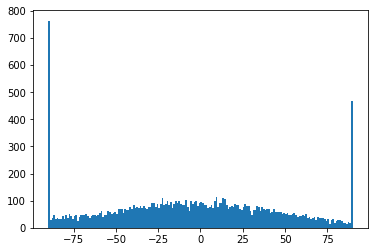

In [404]:
plot_histogram("agent_angles", 60)
#overlap_histogram("agent_angles", [10,60])
#plot_boxplot([25,50,75,100,125])

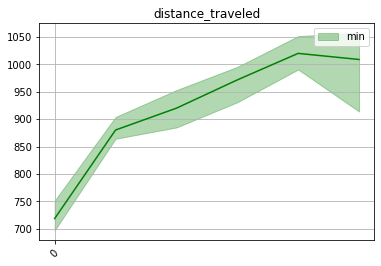

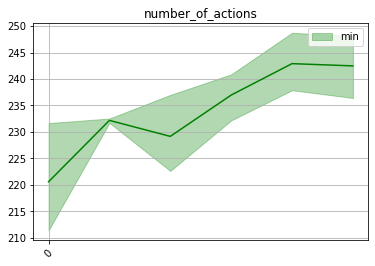

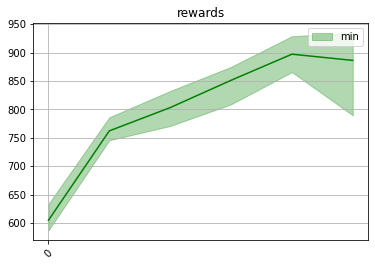

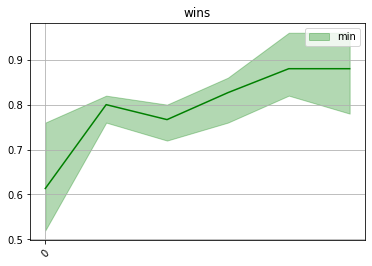

In [329]:
#plot_by_metric("commitment")
plot_by_metric("distance_traveled")
plot_by_metric("number_of_actions") #todo this metrics values are most likely wrong
plot_by_metric("rewards")
plot_by_metric("wins")
#plot_by_metric("avg_steps_per_episode")
#plot_by_metric("optimum_deviation")
#plot_complete_distribution("complete_distribution")

In [353]:
def combine_distri_trajectory(trajectory, distribution, index):

    t_xs = []
    t_ys = []
    for coordinate in trajectory[index][:-1]:
        #t_xs.append(coordinate[0])
        t_ys.append(coordinate[1])
    t_xs = [i for i in range(len(trajectory[index])-1)]
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=80, color='brown', linestyle='dotted')
    plt.axhline(y=-80, color='brown', linestyle='dotted')
    
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('y_coords', color=color)
    ax1.plot(t_xs, t_ys)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(distribution[index]))]
    d_ys = []   
    for coordinate in distribution[index]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:green'
    ax2.set_ylabel('wind', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("distribution_trajectory_combination_{}.png".format(index),facecolor='white', dpi=300, transparent=False)
    plt.show()

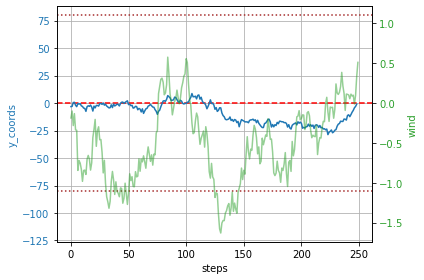

In [383]:
t="[[[4.4034667, 2.241052], [9.08026, 0.29135966], [13.934127, -1.096963], [18.817642, -0.275055], [23.361551, -2.3927157], [27.649504, 0.018744854], [31.825186, -2.7873473], [36.30885, -0.6025082], [41.14781, -1.9028485], [45.779694, -0.19106624], [50.76868, 0.018137662], [55.733166, -0.74254626], [60.683083, -0.17431276], [65.6421, 0.3116264], [70.39049, -1.4884394], [75.39026, -1.7987443], [80.16837, -0.6531203], [85.164474, -1.3308798], [90.01701, -2.8746805], [94.36583, -0.64583504], [99.35999, -0.91938454], [104.30581, -0.7946399], [109.25656, -0.43964297], [114.24234, -1.1659619], [119.181656, -2.191819], [123.67068, -0.20336479], [128.39157, 1.3420992], [129.57722, -3.488826], [132.10378, 0.6973601], [136.76758, 2.2913198], [141.36458, 4.121157], [146.28502, 3.0898442], [150.33095, 0.25280225], [155.3249, 0.10722984], [160.31018, 0.39775372], [164.92978, -1.7570465], [169.81436, -3.1891387], [173.79884, -0.57427907], [178.11902, 1.6054989], [183.0853, 0.74351674], [187.82289, -1.2469531], [192.2658, 0.39391845], [197.25272, 0.11271156], [202.09627, -1.7594907], [206.86499, -0.61273515], [211.28395, 1.5110711], [216.27942, 1.7916834], [221.25854, 1.3968289], [226.25789, 1.6045607], [230.60797, 4.2221074], [235.58643, 4.720573], [240.45004, 3.6041303], [245.44432, 3.2596247], [250.42642, 3.4681008], [255.37999, 4.010443], [259.15067, 0.54911554], [264.1465, 0.31713074], [268.94385, -1.137176], [273.86008, -2.2999573], [278.56982, -0.9201382], [283.20752, -2.7873106], [288.14365, -1.5981774], [293.1187, -0.3924914], [298.01355, -0.732096], [302.96576, 0.8284831], [306.01367, 5.7675734], [311.01205, 6.9521656], [315.50058, 5.844202], [320.2482, 5.450588], [324.15662, 9.570586], [326.86197, 6.407064], [331.85834, 6.837003], [335.13254, 3.4021754], [339.18814, 6.5254636], [344.16705, 6.324464], [349.1667, 6.785283], [354.15738, 6.9125824], [358.9418, 5.79222], [363.56003, 4.1431856], [368.5476, 4.5292106], [373.46796, 5.5322576], [378.38, 6.762313], [382.71945, 4.6018443], [387.68457, 4.0611687], [392.6766, 3.4867165], [397.03674, 5.3844223], [401.19904, 2.1664097], [406.1108, 2.605377], [410.94193, 3.4063544], [415.9216, 3.1936123], [420.7152, 4.1908073], [425.7042, 3.9974384], [430.36755, 5.052469], [434.81235, 2.2899113], [437.39532, -2.581616], [442.34174, -2.3737807], [447.2907, -3.5289671], [452.2402, -4.991195], [457.22012, -6.0857787], [462.2025, -7.030183], [466.71545, -5.2031], [471.02142, -7.89533], [475.11273, -10.787651], [480.10233, -10.847834], [485.06735, -10.6311865], [489.38647, -8.349503], [493.9876, -10.465092], [498.75024, -8.992134], [503.4315, -10.879625], [507.97748, -8.767881], [512.1407, -5.8215766], [516.81116, -4.092827], [521.7914, -3.6391134], [526.5772, -2.3878686], [531.1898, -0.49665838], [536.13477, 0.23609225], [541.1122, 0.6260977], [546.08777, -0.089271665], [550.93665, 1.1176206], [555.7769, 2.6665206], [560.76044, 3.5931854], [565.7363, 4.53267], [570.6487, 5.6629324], [575.63525, 6.111141], [580.62195, 6.5967927], [585.6219, 6.7392187], [590.4316, 8.431014], [594.2775, 5.7777705], [599.2125, 5.6054487], [604.0154, 7.7517447], [608.73224, 10.131049], [612.9638, 8.203889], [617.9638, 8.761808], [622.42523, 7.1959634], [627.42523, 7.848651], [632.40393, 8.880317], [637.227, 10.862175], [642.1366, 12.407603], [647.079, 13.60411], [650.4769, 10.024098], [654.80237, 12.621157], [659.5553, 11.396423], [664.55524, 11.810651], [669.52277, 12.762502], [674.52277, 12.994022], [679.4497, 14.069059], [683.545, 11.526934], [685.1356, 7.1176095], [690.13257, 7.3863], [695.1021, 8.417035], [700.0797, 9.323497], [705.0768, 10.078056], [709.7683, 9.572372], [714.17065, 8.768827], [718.73114, 8.307094], [723.68353, 10.8074045], [728.6634, 13.182467], [733.1799, 17.405806], [737.86896, 17.863409], [742.61395, 18.152163], [746.7671, 17.302717], [751.5489, 17.690609], [754.522, 15.811547], [757.6177, 13.86241], [762.4933, 14.859188], [767.24536, 18.378323], [768.8259, 15.554753], [772.7738, 14.524656], [777.7734, 16.44594], [781.6234, 15.296606], [786.58124, 16.76182], [787.0597, 13.700522], [791.63025, 13.5920725], [795.1416, 12.246753], [800.00275, 13.242684], [803.5705, 12.094322], [807.7443, 11.9102], [811.5873, 11.570179], [816.51276, 15.497388], [821.4874, 17.954927], [825.7537, 18.135452], [827.5321, 16.473715], [830.6872, 15.681689], [834.94196, 16.351667], [837.74414, 15.745665], [842.74225, 19.449356], [846.5907, 20.047094], [850.2624, 20.27477], [853.1958, 19.864456], [856.4141, 19.64887], [857.98016, 18.487154], [862.0421, 18.94662], [864.1336, 17.536514], [868.5406, 18.456509], [871.57446, 17.802341], [874.21985, 16.702827], [878.8683, 17.724945], [882.74866, 17.386433], [887.31006, 17.95933], [891.23987, 17.72508], [895.7223, 18.337147], [900.5785, 20.013397], [905.38916, 21.446543], [909.1778, 21.000431], [912.02747, 19.501715], [915.0042, 18.135685], [919.8786, 19.529846], [924.48285, 19.78882], [927.5413, 18.22769], [931.213, 17.289803], [934.15045, 15.813664], [939.10675, 17.653147], [944.1036, 20.090145], [947.83215, 19.233627], [952.42206, 19.925749], [957.20355, 20.823702], [959.7934, 18.88848], [962.18414, 16.889364], [967.18365, 19.118324], [969.6494, 17.013704], [974.63525, 18.838915], [979.12256, 18.987465], [983.51935, 18.917473], [988.4941, 20.724257], [992.98615, 21.047188], [994.49225, 18.763857], [999.15, 19.505232], [1004.1452, 21.61844], [1007.6938, 20.299927], [1012.6484, 21.65125], [1013.10803, 18.695845], [1017.6711, 18.14608], [1021.45496, 16.414639], [1026.198, 16.35752], [1030.41, 20.537207], [1035.3741, 22.479994], [1039.5421, 21.024523], [1040.3984, 17.454466], [1044.961, 16.701483], [1047.9702, 14.120057], [1052.7905, 14.414935], [1057.644, 17.114115], [1062.3147, 16.66051], [1067.1825, 19.155354], [1070.5946, 16.893856], [1074.473, 21.338728], [1079.302, 21.084986], [1083.6646, 19.959215], [1088.2906, 19.35649], [1092.7797, 22.581886]], [[4.0468235, 3.1144588], [8.953752, 2.4129007], [13.325337, 0.59951884], [18.25454, 1.932582], [22.94952, 0.6663838], [24.864399, -3.5787413], [29.858435, -3.0852559], [33.293785, 0.68582904], [37.492493, -1.9326116], [42.087856, 0.20227584], [46.707478, -1.5688192], [51.188385, -3.6290188], [56.16438, -4.168681], [57.563915, 0.6428376], [61.053593, -2.7650537], [65.32744, -0.3266175], [70.32447, -0.42763728], [75.28586, -1.2578702], [80.08669, -0.1455888], [84.52779, -2.6355147], [88.89451, -0.53974134], [93.89438, -0.5806798], [98.849106, -1.3960797], [102.89138, 1.4221737], [106.699776, 4.314825], [110.02115, 0.29675713], [114.49722, -2.266644], [119.04571, -4.9362187], [123.637024, -3.2101333], [128.39772, -1.8934771], [131.818, -5.829589], [136.75613, -5.4660945], [140.97495, -3.3870192], [145.55212, -2.1401699], [150.46373, -1.9987469], [155.34134, -4.0485744], [159.68962, -2.452906], [164.44589, -1.8034645], [168.99736, -0.5306831], [173.87865, -0.2523028], [178.87532, -0.78124744], [183.82683, -0.7191744], [188.31052, 0.73734343], [193.30946, -0.3192262], [198.18546, -2.0159965], [202.49702, 0.05025671], [207.08217, 1.5052965], [210.26733, -2.843086], [214.85184, -5.325261], [218.16537, -2.0722969], [223.04756, -3.6406517], [227.39186, -1.8453768], [232.36713, -2.0822678], [237.36456, -2.628215], [242.34679, -2.892648], [247.07861, -2.0027318], [252.0381, -2.21191], [256.90482, -1.905766], [261.9025, -2.6924884], [266.7763, -4.556872], [271.77615, -4.9382677], [276.77002, -5.441594], [281.5353, -3.8054094], [286.46448, -2.7726338], [291.0764, -0.789606], [296.06433, -0.55448264], [301.04123, -0.24457012], [305.62366, -2.1267562], [310.6231, -2.1127908], [315.44833, -0.9631307], [320.25818, 0.23417841], [324.95007, 1.6364658], [329.2799, 3.9972386], [332.65192, 0.28205964], [336.86832, 2.9079232], [341.2568, 0.45508093], [344.6043, 4.0340834], [349.59082, 4.408344], [354.46173, 5.414839], [359.32022, 6.658488], [361.28134, 2.1113005], [366.27737, 2.1958349], [371.06577, 0.84244055], [375.84018, 2.4839995], [379.09973, 6.442203], [384.02975, 7.6120763], [388.99942, 7.365773], [390.39447, 2.7994218], [395.39154, 3.130826], [399.60202, 0.8117313], [404.1694, -0.90709764], [408.41595, -2.8540435], [413.40982, -2.4328265], [417.96268, -3.7288084], [422.84622, -3.9727793], [427.59488, -4.778764], [432.44052, -2.696654], [437.33905, -0.75436825], [442.18814, -1.0034044], [447.1781, -0.749275], [452.0644, -1.575753], [455.72507, 2.2530243], [460.72186, 2.288318], [464.59387, -0.7758294], [469.59192, -0.9509778], [474.41156, 0.642327], [478.4458, 4.1043496], [482.62607, 7.202173], [487.2916, 9.145523], [492.22568, 10.477323], [497.09012, 9.743], [502.00394, 9.157144], [506.7537, 7.9813848], [510.22968, 4.922791], [515.20526, 4.9506273], [518.8826, 2.1162713], [523.82025, 3.620549], [528.80566, 4.5629835], [532.53046, 1.903468], [537.5128, 2.1307666], [540.834, 6.3001246], [545.0357, 3.7981849], [546.2262, -0.9560357], [551.0896, -2.117293], [556.0268, -1.327572], [560.28735, -4.038421], [565.1695, -3.1952965], [570.12524, -4.1607533], [575.076, -3.5526202], [580.07416, -3.8619444], [584.71576, -2.3458853], [589.66, -1.863505], [593.74524, 1.0032153], [598.7411, 1.2533536], [603.3909, 2.9841316], [608.3585, 3.4174778], [613.2653, 2.4064267], [617.4002, 5.264611], [622.3762, 5.806983], [626.7114, 8.41986], [631.65955, 9.096287], [636.65063, 9.044958], [641.57697, 7.836142], [646.5651, 7.3891873], [651.28735, 9.039322], [656.05524, 7.619143], [660.5593, 5.6170564], [665.5114, 6.399846], [669.75836, 3.849818], [674.67993, 4.861577], [679.6705, 4.98361], [683.38055, 8.383351], [687.1683, 11.611761], [692.08374, 12.51113], [696.98145, 13.352639], [697.16364, 8.3474865], [702.05164, 7.468365], [706.79584, 9.28487], [711.79486, 9.342871], [715.78613, 6.494804], [720.77045, 6.9058814], [725.705, 7.5897946], [730.3826, 9.267091], [735.2762, 8.281241], [738.9979, 11.254279], [743.7045, 12.5171], [748.30255, 9.984933], [753.2985, 9.208005], [758.24915, 9.262657], [761.4284, 12.4167], [764.15155, 7.519229], [768.59314, 4.3476024], [773.51324, 2.818842], [776.711, 5.951092], [780.7928, 2.0383217], [785.77386, 0.60974884], [788.7539, 3.4131856], [793.13715, 4.682392], [795.67664, 7.717458], [800.60876, 7.2374263], [804.32477, 9.528059], [808.68475, 10.91626], [812.7619, 12.439675], [817.7469, 10.433711], [822.27045, 10.804783], [827.1015, 7.9780307], [831.7107, 4.4994693], [836.33765, 1.2008013], [840.92316, 1.7586445], [845.8391, -0.6965534], [849.6194, 0.75942355], [854.25604, -2.8494883], [858.94226, -2.9860795], [863.9405, -4.6878295], [868.5195, -4.5335], [872.30457, -3.0128982], [875.203, -8.646685], [879.38635, -13.046393], [884.2542, -13.410378], [889.2445, -14.667799], [894.22845, -15.957251], [898.8847, -19.53289], [900.6339, -16.357912], [905.4561, -16.361311], [910.23785, -19.124273], [915.23114, -20.77588], [920.23114, -22.065113], [925.1436, -24.03287], [929.78357, -27.07865], [934.06085, -25.688202], [937.23376, -23.052134], [941.05743, -27.30265], [945.65015, -26.346899], [950.52924, -26.214596], [955.2127, -25.385399], [960.1866, -25.538143], [962.7599, -21.94721], [967.5411, -21.22228], [972.47375, -20.885708], [976.97906, -23.48052], [978.2989, -19.243795], [982.9883, -17.885902], [987.2279, -21.096027], [992.22784, -21.706509], [997.1578, -21.671736], [1001.81116, -24.288921], [1006.7713, -24.453587], [1011.7216, -25.777275], [1016.46313, -25.179913], [1020.7531, -28.861933], [1025.4917, -28.624187], [1029.9338, -27.664366], [1034.7603, -27.7484], [1039.1138, -26.750875], [1043.3729, -25.868616], [1048.1368, -26.123812], [1053.1007, -28.268774], [1057.615, -27.873938], [1062.2157, -27.978046], [1067.1078, -29.018778], [1071.8748, -32.63859], [1076.2261, -32.066654], [1080.5706, -31.60476], [1084.2949, -30.24489], [1089.2277, -33.099804], [1091.2479, -30.445093], [1095.7053, -30.018332], [1100.6503, -31.080786], [1105.2999, -30.854652], [1110.2916, -33.0515]], [[4.117902, -2.6498303], [8.536124, -0.022005474], [13.1545315, 2.19338], [17.745209, 0.5476287], [22.442184, -0.9425433], [27.394873, -1.5227548], [32.381763, -1.8304373], [36.91173, 0.33640856], [40.925148, -2.5325706], [45.22856, 0.033872355], [50.053497, 1.3395717], [53.04565, -2.3506262], [58.021477, -1.673053], [62.307316, 1.1022238], [67.04839, -0.2926956], [72.042076, 0.040574532], [77.03829, 0.19250455], [79.98173, -4.0210795], [84.976425, -3.8133667], [89.27194, -1.4567405], [93.79045, 0.5886742], [98.23746, 2.4402776], [101.70794, -1.7109431], [106.68459, -1.803957], [111.65371, -1.9999902], [116.59395, -3.9379497], [121.427864, -3.6816201], [126.41374, -4.102229], [131.27304, -3.6865728], [136.25656, -5.0009294], [140.9205, -4.05472], [145.89752, -4.611903], [148.77458, -1.6004779], [153.38924, -0.5042359], [158.0216, -3.3177443], [161.46852, -8.081026], [165.8563, -7.0443172], [170.58713, -6.8045816], [175.52898, -7.5526214], [180.09322, -7.082488], [184.8531, -6.94321], [189.35194, -10.595374], [192.37585, -7.940646], [196.25899, -6.2016907], [200.79099, -5.6152577], [205.76094, -6.473569], [210.64969, -6.844531], [213.95442, -4.645874], [218.89479, -5.344074], [223.70467, -8.215892], [228.70422, -9.688875], [233.44861, -9.480127], [235.3916, -6.4561644], [240.37993, -7.901853], [240.48137, -4.473779], [244.5621, -9.04761], [248.12941, -7.2778435], [252.8579, -7.2194505], [257.4162, -6.659504], [261.86523, -5.9885473], [266.62637, -9.04453], [271.48364, -11.560886], [275.74362, -10.60423], [277.12958, -7.5871153], [280.59125, -5.624194], [285.33746, -5.7065406], [290.30914, -8.119507], [295.2998, -10.50995], [300.13422, -11.416295], [305.11215, -13.132137], [308.2454, -11.132973], [312.7869, -10.795682], [316.569, -9.509667], [318.78485, -7.0099583], [322.75027, -5.6588283], [327.74283, -7.150316], [331.568, -12.207438], [336.56784, -14.347464], [338.0491, -11.590529], [342.37744, -11.139935], [346.4693, -10.217201], [350.564, -9.453899], [354.5774, -8.306659], [359.51767, -9.221376], [363.3235, -7.561459], [368.32248, -9.144991], [372.60443, -8.088875], [377.4935, -8.548758], [382.46964, -10.729197], [386.0846, -9.04866], [391.04816, -11.310696], [395.72812, -11.027937], [400.6803, -12.758909], [405.67328, -14.083462], [410.0646, -12.435071], [415.05692, -13.0136], [416.40198, -9.1857395], [421.15125, -8.75452], [425.24982, -7.0627246], [430.1622, -7.2659073], [435.15768, -8.355183], [439.72665, -11.907054], [444.63797, -12.570288], [449.253, -12.535974], [452.87326, -10.964347], [457.8023, -11.759237], [462.2672, -11.254494], [467.2075, -11.955849], [472.12482, -14.267856], [472.46664, -10.342125], [477.46628, -11.161842], [482.42767, -12.49998], [487.2582, -12.055132], [491.85294, -14.942935], [496.849, -15.90091], [501.05865, -14.509423], [504.43097, -12.050941], [509.27875, -12.050575], [513.35803, -10.367699], [517.8154, -13.949132], [522.51355, -13.537281], [527.5089, -14.821969], [531.5688, -19.331297], [535.7071, -18.022627], [539.8169, -16.40166], [541.04694, -12.793679], [545.60144, -12.009009], [550.27606, -11.639642], [553.8498, -9.615768], [558.34705, -8.958175], [563.3151, -10.921957], [565.92993, -8.006856], [569.7319, -6.406052], [574.7144, -8.626022], [579.21606, -12.791727], [584.21277, -14.765235], [589.1923, -16.222002], [593.66895, -15.972445], [598.56335, -16.97171], [602.818, -16.2249], [607.6832, -16.77931], [612.01904, -15.974477], [615.62366, -14.369121], [620.58136, -15.496072], [624.96936, -14.982581], [629.71533, -18.525097], [633.62427, -17.350883], [638.5481, -18.313845], [643.0767, -18.276625], [648.0764, -20.055616], [651.7855, -18.488379], [654.4759, -16.085695], [659.1749, -16.115263], [662.5476, -14.061338], [667.4178, -14.507212], [672.3962, -15.554159], [677.39594, -17.051893], [681.74176, -16.029459], [686.7264, -17.218813], [691.1544, -16.5089], [696.0359, -17.086733], [701.03564, -18.663496], [706.03015, -20.062319], [710.69775, -19.751589], [715.32855, -19.329582], [720.2516, -20.064024], [725.11786, -20.440939], [729.5665, -19.768091], [733.7682, -18.484518], [738.6155, -18.766449], [742.9253, -17.731531], [746.6511, -15.970223], [751.6143, -16.60781], [756.556, -17.008488], [761.5263, -18.654701], [766.5194, -19.54184], [771.3512, -21.788597], [775.5506, -20.174374], [779.52985, -18.25617], [784.3677, -18.208004], [788.9482, -17.446404], [793.38184, -20.827776], [798.3781, -21.620993], [803.0043, -20.720987], [805.98083, -17.940998], [810.88086, -20.19982], [815.6822, -22.685032], [818.3222, -19.900217], [823.2145, -20.454788], [828.1928, -21.71304], [833.0991, -22.315826], [837.95074, -25.207987], [841.73566, -23.708296], [846.1781, -23.383286], [848.0572, -20.847105], [852.2773, -20.404697], [855.6707, -18.923065], [860.65454, -21.294569], [865.61584, -23.964602], [870.0946, -23.7881], [875.08777, -25.518393], [879.39105, -24.950233], [880.205, -21.838722], [884.4734, -21.100882], [889.472, -22.646708], [893.32983, -21.077364], [897.7569, -20.329105], [902.7537, -22.101213], [907.3493, -25.41525], [912.24786, -27.937742], [916.54266, -26.733536], [919.81085, -24.530256], [924.625, -24.768555], [929.6129, -26.127977], [934.4698, -26.227701], [938.5277, -24.44095], [943.04596, -23.559675], [947.82227, -26.079256], [950.3236, -22.893003], [955.06036, -25.525684], [959.476, -28.870214], [962.0307, -25.552738], [966.0946, -23.771294], [970.95264, -25.857023], [975.9419, -26.97392], [980.7022, -29.163803], [984.9043, -26.982891], [988.92755, -24.443134], [993.7076, -26.18501], [998.1338, -24.12671], [1003.0685, -23.601458], [1007.9696, -24.818443], [1012.8285, -23.839682], [1016.8585, -27.019306], [1021.7539, -26.206728], [1026.6886, -27.316818], [1031.5393, -26.108145], [1036.5388, -26.43897], [1041.53, -26.655233], [1046.5029, -26.811571], [1050.4038, -24.276138], [1055.4036, -24.694584], [1059.845, -27.28694], [1063.724, -24.263292], [1068.6447, -25.3973], [1073.615, -25.227161], [1077.77, -22.620314], [1082.4409, -24.360329], [1087.3867, -25.183285], [1092.3848, -25.269981]], [[3.7796063, -3.214474], [8.723291, -3.916534], [13.321546, -2.0006783], [18.27429, -2.7575781], [22.56341, -0.36795893], [27.278774, 1.0888368], [32.06723, -0.8297532], [35.849648, -4.541606], [40.327484, -7.194072], [45.081562, -5.907872], [50.03158, -6.8048205], [54.673634, -5.3081446], [59.33443, -3.783647], [64.04455, -5.614107], [69.01613, -4.9942303], [73.568054, -2.8865209], [78.55902, -2.6216326], [83.36916, -4.130688], [88.00539, -2.4630437], [92.31627, -0.023508452], [96.85023, 2.0337996], [101.836174, 1.7812499], [105.047966, -1.8017266], [109.34801, 0.7695094], [112.924126, -2.578879], [117.12903, 0.303644], [120.76345, -3.0624611], [125.34423, -0.9153168], [129.79355, -3.295422], [134.72614, -4.182545], [139.70554, -3.5275674], [144.70004, -3.1081264], [149.1606, -0.78557867], [154.05667, 0.2786731], [157.10329, -3.5972345], [161.66048, -1.3832623], [166.63103, -0.9235527], [171.59091, -1.6078699], [176.5771, -2.300033], [177.62231, -7.265829], [181.97842, -5.0394564], [186.94331, -4.8193936], [191.78731, -4.135113], [196.77364, -4.210492], [201.75389, -5.071005], [206.68176, -4.931615], [211.15102, -3.5161195], [214.58987, -0.68946195], [219.47853, -2.6689165], [224.46207, -3.952176], [228.51515, -7.8038826], [233.3559, -7.685353], [238.17477, -7.4142885], [238.94617, -3.5449336], [243.83707, -3.710154], [248.10158, -2.6450796], [253.06384, -5.0451684], [257.4169, -4.6194754], [262.049, -4.7497206], [267.03577, -6.224131], [271.9826, -7.6941533], [276.97787, -9.951867], [281.46097, -9.982706], [284.36276, -8.255285], [289.36273, -10.720035], [293.07477, -10.029626], [297.30338, -10.29661], [301.66327, -10.869771], [304.85638, -10.11914], [305.64267, -8.049125], [310.63275, -11.341263], [315.32135, -12.576601], [320.186, -14.54625], [323.2449, -13.681343], [327.84125, -14.643678], [330.02945, -13.014211], [330.77893, -11.118509], [335.73486, -14.676805], [339.52988, -14.387277], [343.23917, -13.982785], [346.3265, -12.850549], [350.01477, -12.267147], [353.11996, -11.404524], [357.7981, -12.607115], [360.88348, -11.9127865], [365.12296, -12.469234], [369.61523, -13.30089], [369.8175, -11.513831], [371.05334, -10.034469], [375.0476, -10.294355], [379.43686, -15.937418], [380.92764, -14.385584], [383.22977, -13.051584], [385.7553, -11.647942], [388.8764, -10.906378], [393.8616, -13.985902], [398.82367, -16.91702], [399.30942, -15.437745], [402.3238, -14.94972], [406.76797, -16.058668], [410.94528, -16.82129], [413.64114, -16.00953], [417.0586, -15.772418], [420.70514, -15.561992], [424.72818, -15.501932], [429.57388, -16.823666], [432.53235, -15.189511], [437.49606, -16.844618], [442.20944, -17.330986], [442.20944, -14.554585], [443.79733, -12.089538], [448.38657, -16.426048], [450.69556, -14.134553], [454.4868, -13.070401], [457.0728, -11.286338], [461.33548, -11.208176], [466.3127, -14.191571], [470.80865, -14.483556], [475.75433, -17.673178], [479.4083, -16.807165], [482.95526, -16.09489], [486.52884, -15.744517], [489.8402, -15.29297], [494.50574, -17.02435], [498.8323, -18.24972], [500.17944, -16.986494], [504.20554, -17.792168], [508.06805, -18.506205], [512.0685, -19.322676], [516.0362, -20.272665], [520.21014, -21.349096], [522.5924, -20.647404], [525.8304, -20.457424], [530.508, -22.385292], [531.60986, -21.413567], [536.5573, -24.451612], [540.5245, -25.028654], [544.4101, -25.375368], [548.9755, -26.733166], [553.3524, -27.708836], [555.85803, -26.91978], [557.8637, -26.103765], [561.4837, -26.318514], [565.26245, -26.520947], [568.63354, -26.222227], [572.80255, -26.928614], [577.165, -28.009567], [582.0895, -30.713299], [583.9152, -29.71608], [587.2511, -29.872961], [588.7256, -28.940998], [591.5864, -28.514257], [595.887, -29.54006], [600.82446, -32.51183], [602.95154, -31.543526], [604.9348, -30.753897], [608.8098, -31.369617], [613.4562, -33.50406], [616.47766, -33.71851], [621.311, -36.85756], [625.3297, -38.13664], [630.22327, -43.397404], [634.6794, -45.356094], [638.4307, -46.228363], [642.67065, -47.57677], [646.6716, -48.591515], [646.6716, -47.40786], [650.21814, -47.529644], [653.8948, -47.81888], [656.6813, -47.338345], [661.42114, -49.411465], [662.36646, -48.092434], [663.20746, -46.730183], [663.20746, -45.21344], [666.5001, -45.01756], [670.33325, -45.334213], [674.17, -45.7592], [674.17, -44.378387], [677.73047, -44.409748], [680.7204, -43.86103], [685.2392, -45.116257], [689.97235, -46.914066], [691.1106, -45.568928], [695.61426, -46.956863], [697.95197, -46.014023], [701.4481, -46.097435], [704.3028, -45.486553], [706.743, -44.592842], [708.2986, -43.34858], [713.10956, -45.374382], [717.3801, -46.25769], [721.07245, -46.4282], [723.6198, -45.69666], [726.5353, -45.053158], [727.31775, -43.169804], [732.2997, -45.739243], [735.29376, -44.650112], [736.7686, -42.73362], [738.51495, -40.78212], [739.339, -38.528046], [740.9192, -36.412457], [745.3745, -36.75438], [748.8244, -35.887527], [752.8641, -35.70558], [757.434, -36.631298], [761.3085, -36.249043], [763.9769, -34.955055], [768.406, -35.438675], [771.42145, -34.32048], [775.7719, -34.630955], [779.4182, -33.90764], [779.57623, -31.36579], [781.8736, -29.355703], [783.71674, -27.096144], [788.0825, -27.057257], [790.43884, -25.001219], [790.43884, -22.422815], [795.24036, -26.187979], [798.9207, -25.325838], [802.4358, -24.447533], [805.35187, -22.980865], [809.6491, -23.085985], [813.69434, -22.827085], [816.40234, -21.20716], [821.2785, -22.683771], [823.3137, -20.783533], [826.84875, -20.003792], [831.72943, -23.816772], [833.29596, -21.613335], [838.26373, -24.923864], [842.2694, -24.562912], [842.2694, -22.174171], [847.26056, -24.606989], [851.4875, -24.726328], [856.37964, -26.564962], [857.8315, -24.652718], [859.8131, -22.889524], [862.6733, -21.645864], [867.2944, -22.580624], [872.11835, -27.001892], [874.45404, -25.793085], [878.8068, -26.469477], [882.193, -25.982834], [883.84296, -24.657896], [888.8225, -27.595232], [893.7903, -30.432934], [895.44244, -28.936573], [897.0007, -27.136532], [901.94037, -29.276493], [905.72174, -28.967127]], [[4.6619296, -1.7585396], [9.55041, -2.628763], [14.315979, -0.78356797], [19.189352, -1.5765921], [23.96712, 0.22446735], [28.046083, -2.1434653], [32.235355, 1.1600124], [36.76859, -0.5101033], [41.73464, -0.86147326], [46.725098, -0.35604057], [51.724926, -0.12689848], [56.094482, 2.6907878], [56.392056, -1.7211196], [61.37211, -0.7981532], [66.32777, -1.147133], [70.3918, 2.2360363], [74.41129, -0.23683374], [78.96761, -1.9546897], [83.91409, -0.741957], [88.63593, 1.6656374], [92.88401, -0.29194677], [97.879715, 0.11041942], [102.82217, 1.4036543], [107.76421, 1.1574215], [112.75119, 2.1497107], [117.21066, 0.35928273], [122.20196, 0.6979672], [126.56896, -1.0729241], [131.39864, -1.4170182], [136.20981, 0.7559045], [141.0226, 2.637948], [145.9845, 2.6067023], [150.3357, 0.753506], [155.19734, 2.2740302], [160.05208, 1.1744665], [163.18582, -2.435168], [167.78261, -0.05955142], [172.78084, 0.7111747], [176.3107, -2.1724114], [179.24184, 2.53394], [184.22096, 2.8356962], [189.12671, 2.7785373], [194.01524, 2.545002], [198.01332, 0.32036972], [202.98405, 0.8646311], [205.30711, -2.4720423], [209.29572, -4.4517293], [213.89156, -1.5623301], [218.89134, -0.7047792], [223.87259, 0.73747474], [228.64003, 3.2635527], [233.3435, 2.7388186], [237.62718, 6.254329], [241.45966, 3.8633394], [246.45958, 4.62953], [251.45198, 5.2412863], [256.3986, 5.350194], [261.31366, 7.0466795], [266.00616, 6.126898], [270.67947, 5.1927447], [275.55048, 4.6061144], [279.18625, 1.5207942], [284.1847, 1.6511538], [288.6664, -0.22169282], [293.52863, 1.2454863], [295.45578, -3.00878], [300.24725, -4.126972], [304.57047, -1.1842374], [309.57047, -0.48415697], [314.55304, 0.44843483], [319.39993, -0.15501143], [324.14572, 1.8770987], [328.8583, 3.9226751], [333.85828, 4.2323837], [337.63696, 0.9921556], [342.57907, 1.5210457], [347.57535, 1.2078398], [352.27765, 2.6958687], [357.27597, 2.0887594], [361.84772, 3.6117597], [365.44794, -0.5430431], [369.895, 1.0202931], [373.13113, -3.6741858], [377.96918, -3.1171508], [382.8703, -2.8525345], [387.71964, -2.3135293], [392.70792, -2.5893214], [397.44797, -4.7899346], [402.18655, -7.135412], [406.27365, -10.814064], [410.5726, -9.042826], [415.51254, -8.831356], [420.33054, -7.871007], [424.8798, -5.9957404], [428.21506, -9.981412], [431.40002, -6.0627465], [436.29178, -4.7144246], [440.84396, -2.5458698], [445.76456, -3.2201223], [450.7401, -2.5187747], [455.62894, -1.2148303], [460.4959, -2.298029], [465.4208, -1.3484343], [470.39432, -0.706218], [471.68097, 4.674646], [476.53455, 4.0749], [481.53268, 4.739262], [486.49744, 5.956209], [491.2042, 5.167714], [496.00952, 4.586948], [500.68103, 3.4477363], [505.649, 4.763259], [510.64432, 5.7262516], [515.6436, 6.6361213], [519.4708, 4.2208943], [524.4317, 4.6340537], [529.0702, 3.8635888], [533.0956, 2.025662], [537.5063, 5.7216573], [542.4284, 8.127911], [547.22253, 8.298359], [552.16003, 9.013695], [557.0894, 9.548781], [560.84155, 7.72256], [565.84125, 9.065359], [570.76245, 9.588009], [575.6915, 11.744949], [580.039, 10.47266], [584.85834, 10.396696], [589.60315, 10.201104], [594.5786, 11.07322], [599.4906, 11.636275], [604.4866, 12.901159], [606.73926, 9.881288], [611.3466, 9.284145], [616.1916, 9.517273], [621.02484, 12.13344], [625.5077, 10.923395], [629.84015, 9.089788], [634.70984, 10.693536], [639.7097, 11.137772], [640.686, 6.7166867], [645.67847, 7.1142287], [650.6779, 7.803892], [655.67377, 8.545239], [660.66003, 9.38629], [665.6489, 10.135213], [670.34955, 12.364626], [674.2315, 9.701466], [679.0012, 8.647981], [683.3087, 11.5888], [688.21716, 11.11325], [693.21716, 11.427098], [698.2133, 11.966888], [702.96094, 13.771296], [706.2571, 10.230074], [711.0423, 9.348272], [715.97833, 9.144436], [720.9129, 10.442102], [725.8505, 11.760135], [730.8316, 12.460677], [734.6272, 9.434015], [739.5415, 8.959564], [744.4943, 8.492072], [749.42633, 9.488544], [754.219, 11.150222], [759.1972, 11.112506], [763.99524, 12.875321], [768.9715, 12.73414], [773.8863, 13.742809], [777.1522, 9.984277], [781.9111, 8.452264], [786.53033, 10.092164], [790.45386, 6.437356], [795.26996, 7.2709885], [800.04266, 8.3438], [804.5413, 5.626406], [809.54114, 4.956227], [814.146, 5.955467], [818.32306, 7.638678], [823.30597, 6.830255], [827.99207, 3.938552], [832.7898, 3.84258], [837.44824, 0.6741072], [842.0416, 1.5380576], [846.9376, 1.5764346], [851.8495, -0.3748561], [855.6965, 1.8936169], [860.54974, -0.67359567], [864.4124, 1.0360861], [867.92804, 2.9592907], [871.2205, 5.1057487], [875.6333, 5.6787214], [879.836, 6.643449], [884.38214, 2.8548503], [889.13544, -0.007932758], [893.9342, -0.013928745], [898.11926, 1.4888105], [901.58105, 3.9385257], [905.40656, -0.32180813], [910.38464, -0.8556991], [915.2301, -2.9190001], [920.1806, -4.516181], [924.63684, -7.5976295], [929.0308, -10.844826], [934.02893, -11.652057], [938.9819, -12.109693], [943.25946, -10.446076], [948.0735, -9.983139], [953.06, -10.424603], [957.778, -9.651593], [962.7478, -10.904894], [967.7353, -11.29911], [972.3091, -10.091494], [977.2851, -10.556686], [982.25006, -11.04664], [986.0901, -15.278541], [989.92004, -12.775879], [994.80304, -14.483052], [997.8869, -19.134985], [1002.43475, -17.7608], [1007.39667, -17.694246], [1012.3449, -17.232458], [1017.33514, -17.32529], [1021.7716, -19.967264], [1026.664, -21.438799], [1030.9949, -19.611958], [1035.7849, -18.898966], [1040.6316, -18.454706], [1045.576, -19.79224], [1048.8353, -16.54817], [1053.7306, -16.226538], [1058.7208, -16.568388], [1063.2385, -15.0101385], [1067.832, -17.859573], [1072.832, -18.765348], [1077.0587, -17.1469], [1081.7026, -20.241507], [1086.648, -22.29001], [1091.4749, -22.177605], [1096.1974, -21.601662], [1101.196, -22.777145], [1106.1277, -23.10794], [1110.9667, -23.137543], [1115.596, -26.322496], [1120.5896, -27.47133], [1125.4395, -30.01645], [1130.3738, -32.13912], [1133.2551, -29.229149], [1135.0529, -25.577394]], [[4.7322364, 1.6235507], [8.697816, 4.5126185], [13.460624, 3.0466807], [17.210966, -0.18973793], [21.916412, -1.770494], [26.734856, -3.0662715], [31.679482, -3.9782395], [34.259586, 0.12943865], [38.615936, -2.690067], [42.960358, -0.5968539], [47.960205, -1.0197575], [52.56495, 0.5212386], [57.186394, 1.9121859], [61.34195, -1.4528224], [66.08255, -3.4285455], [69.85186, -0.5733906], [74.85016, -1.0021112], [79.848724, -1.3311903], [83.94276, 1.0909121], [88.14481, -1.8219066], [92.87565, -0.60240495], [97.72201, -2.0672915], [102.71658, -2.6339486], [107.16067, -0.8068949], [112.15884, -1.3019416], [116.28032, 0.93197733], [121.11921, -1.0225883], [126.11076, -1.2141522], [130.73665, -3.7662456], [135.73155, -4.3137074], [139.6968, -1.7016021], [143.86491, -4.79335], [148.30806, -2.8418293], [153.07445, -1.5114625], [157.44592, 0.96076375], [162.35085, 2.088865], [167.33904, 1.9066279], [171.50813, 4.7371817], [174.24928, 0.8259264], [179.24788, 1.0977007], [183.42505, -1.326979], [188.37071, -0.1852937], [193.34814, -0.37716395], [197.51402, 2.925482], [202.50256, 3.2672348], [207.02663, 1.7563492], [211.2757, -0.24972287], [215.78922, -1.8278075], [220.69919, -0.3204181], [224.54958, 3.4464266], [228.87741, 6.7829986], [233.81158, 8.441397], [235.49527, 4.674788], [240.42899, 4.8564177], [243.3394, 1.674493], [247.93857, 0.5169904], [252.71179, 0.04845391], [257.22083, 3.4056695], [262.00986, 5.997517], [265.8614, 4.143524], [270.68552, 4.3206406], [275.663, 5.3091364], [280.5387, 5.872829], [285.25677, 9.340628], [289.6404, 8.718134], [294.20242, 8.32437], [297.272, 6.1254683], [302.268, 7.739612], [307.0777, 8.23015], [309.9047, 6.1592417], [314.7517, 7.186574], [318.2291, 5.8467455], [323.2197, 7.492943], [327.7753, 7.4591565], [331.41183, 6.111536], [336.05142, 6.2041917], [340.96884, 9.200128], [344.06195, 7.1959157], [347.4038, 5.410806], [352.1227, 8.934375], [355.7533, 7.4522314], [360.42645, 7.457953], [365.35104, 10.00934], [367.5782, 7.4590034], [372.5736, 9.724673], [376.71, 8.581922], [381.68887, 10.582923], [384.45923, 7.9441247], [389.2693, 8.191825], [394.1883, 10.472719], [396.90955, 7.8158326], [401.1606, 6.5196114], [405.8898, 9.297249], [410.4942, 8.396169], [415.24057, 7.642376], [420.08243, 7.2694774], [424.83365, 9.836985], [428.92267, 7.8399677], [433.26184, 6.1381745], [437.92007, 5.169779], [442.91687, 6.021214], [447.90915, 6.6219106], [452.8955, 7.1947846], [457.82275, 7.6346736], [462.819, 8.796058], [467.63733, 9.08276], [471.51035, 7.3321486], [475.5457, 5.894809], [480.15726, 9.320565], [483.29672, 6.732297], [488.21378, 8.968806], [490.9499, 6.251596], [495.8784, 6.870663], [500.83096, 8.871526], [505.82626, 10.238077], [510.80725, 11.493253], [515.2248, 10.696538], [520.10223, 13.475079], [523.48016, 11.555741], [527.69275, 10.491605], [532.57446, 10.958139], [536.3393, 9.015516], [541.13116, 8.99823], [545.8394, 9.245438], [550.3895, 13.380599], [555.3845, 15.706123], [559.85443, 15.504549], [562.6606, 13.09848], [567.1809, 12.89175], [571.3852, 12.091486], [574.0433, 9.586151], [578.1744, 8.473834], [581.89325, 13.350552], [585.1708, 10.9550295], [588.439, 8.511636], [593.31366, 8.869633], [598.0592, 8.557904], [603.05164, 9.47649], [608.038, 10.855098], [612.6404, 13.799338], [617.63055, 14.370711], [620.10944, 10.892988], [624.9706, 12.771627], [628.77106, 10.22365], [633.67535, 9.752353], [638.3415, 8.431573], [643.32166, 8.327258], [648.2058, 9.736466], [652.81537, 8.28642], [657.815, 8.963681], [662.7177, 8.883613], [666.86743, 12.764961], [671.6402, 12.546881], [676.59937, 14.53844], [681.5134, 14.945087], [684.1359, 11.940398], [689.0622, 12.430626], [692.26245, 9.786503], [697.2576, 11.0055], [702.2451, 12.531585], [707.0375, 15.332102], [711.832, 15.46587], [715.4562, 13.561581], [719.80426, 12.6145735], [724.7962, 14.571207], [729.4573, 14.113822], [733.8092, 12.71357], [738.7886, 12.856006], [743.63043, 12.381935], [747.91864, 10.624672], [752.64886, 13.034084], [756.89813, 11.221148], [761.5671, 10.483991], [766.05676, 8.833771], [771.01715, 8.462537], [775.129, 11.416285], [776.94385, 6.920662], [781.82025, 5.8792863], [785.5738, 9.2876005], [789.41223, 12.76301], [794.3889, 12.279922], [799.38885, 12.687576], [804.3605, 12.617177], [809.33374, 12.713471], [814.2852, 12.598119], [819.2603, 13.825097], [824.11035, 15.654531], [825.9336, 11.647438], [830.75244, 13.76413], [835.7504, 14.577141], [840.7241, 14.948279], [845.33484, 13.727678], [850.31775, 15.152273], [853.8037, 12.29216], [858.2099, 10.845579], [863.0255, 12.929484], [867.7094, 15.231736], [871.1848, 12.081345], [876.1796, 12.075604], [881.12683, 13.033787], [884.44226, 9.559198], [888.6694, 12.543952], [893.64294, 12.357139], [898.5359, 13.72508], [903.5344, 14.013912], [908.5256, 14.712112], [913.2123, 13.332932], [917.9553, 15.008199], [922.8558, 16.2118], [927.0706, 13.827427], [931.4699, 11.681618], [936.4652, 12.213422], [940.29816, 9.273582], [945.2744, 9.917408], [950.26874, 9.847475], [954.69885, 12.161158], [959.4987, 10.848916], [963.2763, 7.7038326], [968.12067, 6.4803696], [972.91486, 8.238919], [977.74115, 7.274916], [982.70496, 7.138307], [987.70416, 7.6048946], [992.67523, 7.720735], [997.6585, 8.848051], [1002.52344, 10.519144], [1007.5168, 10.897495], [1011.5674, 14.634102], [1016.5509, 15.75674], [1021.41833, 15.506438], [1026.2352, 18.00688], [1031.1633, 18.380013], [1035.7982, 21.499617], [1039.939, 19.766233], [1044.3322, 18.452196], [1048.8372, 17.509382], [1053.6622, 17.454079], [1058.4465, 17.317299], [1063.1863, 17.040627], [1068.1322, 17.693977], [1072.136, 16.256456], [1077.1355, 18.017447], [1080.9366, 16.42251], [1085.8911, 17.350649], [1090.818, 18.068022], [1095.7501, 20.356705], [1099.2611, 17.82195], [1104.1366, 17.86236], [1109.1183, 18.579775], [1114.075, 19.384401]], [[4.93114, 0.89990443], [9.728072, -0.5683482], [14.704833, -0.8813044], [19.636606, 0.30523667], [23.9513, -2.0017724], [23.9513, 3.3725872], [28.782536, 2.6216965], [33.296448, 0.68346167], [36.474144, -3.006992], [41.01527, -5.166358], [46.01412, -5.3782306], [51.014065, -5.583163], [55.802258, -4.5155015], [60.66505, -3.741269], [65.61217, -3.2730143], [70.60453, -3.1919332], [71.80687, 1.2870212], [76.168236, -1.5000268], [81.114944, -1.0964378], [86.114426, -1.6077162], [91.098076, -1.8347719], [96.068054, -2.2401283], [100.92912, -2.1359215], [105.88317, -3.814781], [110.47372, -2.614647], [115.072685, -1.3568767], [118.44513, 1.9049782], [122.29601, -1.7054104], [125.97934, -5.4615483], [130.71298, -4.4491525], [135.69125, -4.675933], [140.5217, -4.3187222], [145.31201, -3.9305847], [150.257, -5.964214], [153.69081, -3.2945185], [158.00705, -1.6244733], [162.97366, -1.6124293], [167.9247, -1.263121], [172.66472, -0.12397857], [177.62915, -0.03580615], [182.06158, 1.6005386], [187.04842, 1.3493859], [190.68677, 4.086519], [194.42703, -0.021556692], [199.42665, -1.1128806], [204.41827, -2.4180162], [209.3909, -2.803109], [214.39088, -3.651928], [217.28581, -0.3215607], [222.08351, -2.5108297], [227.06316, -3.9852905], [231.70866, -6.663999], [235.33286, -4.0966544], [240.23366, -3.8489974], [244.96655, -6.314171], [249.47191, -5.2395473], [254.46161, -5.848096], [257.3951, -2.485246], [261.86618, -0.7065083], [265.6925, 2.069911], [269.65366, 4.76419], [274.63284, 4.226867], [279.5714, 3.315482], [284.3815, 1.8536804], [289.30685, 1.1096884], [294.14743, 0.040902067], [298.7801, -1.8112798], [302.8929, 0.8524336], [307.85965, -0.035005342], [311.73505, 3.052426], [316.63934, 2.039293], [321.49603, 3.089411], [326.47864, 2.7351356], [331.2466, 1.4146394], [335.34213, -1.363079], [339.51535, -3.8125503], [343.05658, 0.061223112], [347.80878, 1.621801], [352.75955, 2.4173129], [356.94656, -0.0317046], [361.88022, 0.927917], [365.67245, 4.509907], [370.57275, 5.7013], [375.56955, 6.1558127], [380.29593, 8.155068], [385.12836, 7.2015343], [389.6139, 5.385307], [392.95013, 9.308529], [395.55127, 5.424155], [400.52585, 6.048165], [405.13895, 8.041412], [407.91394, 4.0786257], [411.15887, 8.101006], [416.0754, 7.4258256], [420.16214, 4.9707017], [425.07312, 4.6972475], [430.06625, 5.1001534], [434.3955, 3.4882243], [439.3678, 4.80957], [444.1618, 6.977075], [448.75485, 5.854264], [453.69766, 5.959677], [458.13547, 4.671121], [463.0397, 6.854879], [468.03217, 8.29019], [472.9682, 10.301517], [476.85483, 8.644599], [480.4341, 6.3142285], [485.19656, 9.177492], [489.78207, 8.272584], [493.5565, 5.942014], [498.49252, 6.1865335], [503.22424, 8.662795], [507.72556, 7.398055], [512.7021, 7.987924], [517.53204, 10.575013], [521.6032, 8.935287], [526.5802, 10.414454], [531.2917, 9.554861], [534.1865, 6.3490486], [539.0934, 6.0667543], [543.9222, 5.520486], [548.6832, 7.7840695], [553.52606, 7.16207], [558.52594, 7.7751365], [562.80994, 10.870138], [567.42993, 9.54782], [571.9932, 12.378408], [576.2999, 10.568511], [579.1701, 6.969507], [582.6631, 3.8291032], [587.093, 6.488697], [592.05, 5.932305], [596.77545, 4.672608], [601.769, 5.746421], [606.7283, 7.2939525], [611.7221, 8.396469], [616.38696, 7.2801466], [621.0203, 5.9134493], [626.0194, 6.376307], [629.68365, 3.69962], [634.1787, 6.3821907], [638.3863, 9.55678], [643.1892, 11.407225], [647.96967, 10.431373], [652.96936, 10.918952], [657.7733, 10.028718], [662.7094, 11.564333], [667.40906, 10.5995655], [672.4066, 11.41906], [675.0603, 7.880234], [679.6912, 6.4708123], [684.4237, 5.311496], [687.5235, 9.804871], [692.49554, 10.009772], [696.2982, 7.428088], [701.2704, 7.3643436], [706.19226, 8.5408125], [709.7848, 5.5178137], [714.66254, 7.2010317], [719.21124, 9.828202], [724.07666, 11.782764], [728.7938, 10.810862], [733.4516, 9.746546], [738.3795, 11.212514], [742.28986, 8.8576975], [746.4181, 6.805934], [751.41797, 7.4042306], [756.3883, 7.525445], [761.36676, 8.616235], [766.0618, 7.5380845], [770.9515, 9.553395], [775.85034, 9.439175], [780.7499, 11.057732], [785.74945, 11.091403], [790.66986, 10.193674], [795.6624, 10.224708], [800.11816, 12.812024], [804.9235, 11.711649], [809.5964, 10.294709], [813.57776, 13.613102], [818.55176, 13.281076], [823.5058, 14.186765], [825.56494, 10.137654], [828.8131, 14.366761], [833.5728, 16.403896], [838.4177, 15.798355], [841.05426, 12.038203], [845.5914, 14.772105], [850.5627, 14.648375], [855.29486, 13.504273], [860.0702, 12.392347], [864.9542, 11.809756], [869.88934, 12.996403], [874.45807, 11.389247], [878.9725, 13.848615], [883.2569, 16.410852], [887.38586, 13.30611], [890.7134, 9.063536], [895.7109, 8.430907], [900.3746, 6.1883755], [905.37164, 5.7279515], [910.07764, 7.402354], [914.8751, 8.91897], [919.37054, 6.853828], [924.123, 5.5651956], [928.6974, 7.93747], [933.2255, 10.275602], [938.08185, 11.350324], [943.0263, 12.048333], [948.02606, 12.105307], [953.02246, 12.04605], [958.0013, 12.494354], [962.99646, 12.874773], [967.9251, 13.767715], [972.5808, 15.653876], [976.4226, 12.474247], [980.8858, 10.104008], [985.8304, 10.842814], [990.82776, 10.926566], [994.63135, 7.491531], [998.67084, 4.67487], [1003.1766, 7.051368], [1008.1002, 8.287228], [1013.09753, 8.544237], [1017.1388, 11.783065], [1021.29114, 15.072404], [1025.8834, 17.383524], [1030.7499, 16.29455], [1035.2585, 14.119286], [1040.0288, 12.617282], [1045.0249, 13.028616], [1049.9849, 12.587842], [1054.2102, 15.424633], [1058.7324, 13.344912], [1063.7322, 13.204918], [1068.5449, 14.230268], [1072.4456, 10.628789], [1077.0497, 12.010911], [1080.7876, 14.870242], [1084.7505, 11.061127], [1089.355, 8.450319], [1093.0088, 11.216982], [1097.2535, 13.465816], [1102.2151, 13.492508], [1107.0978, 13.925632], [1111.7512, 11.336284], [1116.7496, 10.693972], [1121.4662, 11.740849], [1126.1035, 13.014092]], [[4.897518, -0.98010516], [9.418876, -3.0039485], [13.826145, -0.40072247], [18.432056, -1.8317534], [22.50413, -4.5619493], [26.620129, -7.1150703], [30.721579, -4.0911856], [35.72023, -3.6444767], [40.68559, -2.880844], [45.534454, -3.9476445], [49.16681, -0.10688775], [54.16233, 0.4482321], [59.14658, 0.49746248], [63.8992, -0.6650538], [68.42723, 1.845718], [73.37518, 2.9809244], [77.999954, 1.3421915], [82.97759, 2.0097563], [87.85108, 1.1263747], [92.206635, -1.0389678], [97.11835, 0.17718853], [101.75532, 2.5715878], [106.74089, 2.4974785], [111.65431, 3.7526617], [114.392075, -0.13017638], [119.06243, 1.9114634], [123.970764, 1.0695733], [128.68777, -0.5898393], [132.96274, -3.1508818], [135.10759, 1.3457248], [140.09354, 1.8870018], [145.0572, 1.3508247], [149.31465, -1.4133161], [154.30998, -1.7651143], [159.30583, -1.5635966], [164.29831, -1.1804576], [169.11787, 0.3589711], [174.00613, 1.7539204], [178.5059, 4.334215], [183.31621, 3.205734], [187.9305, 1.4026262], [192.90298, 1.9975188], [197.35345, -0.52571803], [202.26863, -1.4421967], [207.07405, -0.10469232], [212.04088, 0.32421768], [216.98782, -0.67914486], [221.88812, 0.046476725], [226.8405, -1.0463197], [231.65486, -2.6750588], [236.6427, -2.4038503], [241.54372, -1.4325321], [246.54195, -1.2284685], [251.53818, -0.8947357], [255.22707, 2.5590842], [260.19543, 2.9150515], [265.16077, 2.2198324], [267.69012, -2.2493436], [272.59048, -1.566538], [277.41812, -0.30498162], [282.09055, 1.1914644], [287.08936, 0.92217433], [291.77026, -1.3134671], [295.6926, -4.840076], [300.5619, -3.8196678], [304.40738, -7.1344476], [308.85284, -4.9076037], [313.84122, -4.556852], [318.27762, -2.1388261], [323.24664, -2.6238694], [328.2422, -2.9391496], [333.0887, -4.46518], [338.08734, -4.736351], [343.03442, -4.3508906], [347.6201, -2.4687288], [351.92413, 0.24422762], [356.14447, 2.9928567], [361.1239, 3.5525525], [363.91913, -0.30172163], [368.87512, -0.84848654], [373.39185, 1.3851479], [378.37772, 1.1518109], [383.0654, -0.91518915], [385.7392, 2.8963728], [390.05914, 5.070848], [394.10522, 1.5111938], [399.01987, -0.045169875], [403.50238, 1.5194564], [408.4765, 0.4347217], [413.42816, -1.3094949], [416.26154, 1.607183], [421.05637, -0.99171543], [426.05273, -2.2411187], [430.28613, -0.7758474], [434.98895, -0.14418747], [439.91635, -2.082071], [444.7891, -4.11255], [449.7867, -5.2342305], [454.4854, -4.341598], [459.48392, -5.441496], [464.3738, -7.357548], [469.1001, -6.9888754], [471.99017, -4.04456], [476.98993, -5.4418864], [479.42575, -2.3469753], [484.19812, -4.7600102], [489.18085, -5.134751], [493.97885, -4.6384296], [498.1141, -2.9570465], [503.07962, -4.7839923], [508.0342, -5.4208965], [513.0301, -6.4466825], [517.9243, -7.0535207], [522.655, -10.253518], [527.58923, -12.568354], [532.5499, -14.531719], [535.12115, -11.412941], [539.6148, -14.793013], [543.96484, -13.598336], [546.78424, -10.799852], [551.5985, -10.625329], [556.5955, -11.735181], [559.36633, -8.913857], [564.1963, -11.668682], [569.1493, -13.728205], [573.3639, -12.212884], [577.8446, -11.214752], [582.37946, -10.310964], [587.3751, -11.847028], [592.3297, -12.231865], [597.20844, -12.238408], [602.07477, -14.734255], [605.7965, -12.946211], [609.3339, -10.838848], [614.0801, -10.892661], [619.02045, -11.692565], [624.0061, -12.736413], [629.005, -14.089853], [633.65533, -13.3433], [638.3888, -15.932989], [643.2901, -15.935407], [648.28973, -16.91373], [653.18823, -16.785858], [658.1805, -17.369717], [660.2217, -13.473295], [665.22156, -14.038893], [670.2047, -14.871573], [674.37604, -12.67879], [679.37585, -13.070479], [684.0919, -15.00831], [688.598, -12.854926], [693.49274, -14.013573], [698.4118, -14.769246], [703.4044, -14.830561], [707.88495, -16.677288], [712.26697, -18.598436], [716.4301, -15.140905], [721.40643, -13.84036], [726.3453, -13.771169], [731.3452, -13.015697], [734.75635, -8.8637905], [739.0645, -11.01289], [743.993, -9.955534], [747.4606, -13.421819], [750.8462, -9.678057], [755.15674, -7.101665], [758.90814, -3.7229154], [763.4688, -5.562747], [768.18243, -6.770721], [769.8122, -11.1076355], [774.8093, -10.73381], [779.4822, -8.867086], [784.39923, -9.698297], [789.31165, -8.62735], [791.7075, -3.906823], [796.62573, -4.358562], [801.5921, -3.5200734], [806.3152, -5.2052336], [811.3097, -5.3477545], [816.30554, -5.5429726], [819.9045, -2.0095751], [824.8227, -0.93557143], [829.2505, 1.7379345], [833.7256, 4.0800915], [837.13135, 7.7157125], [842.08185, 6.9118147], [846.8076, 5.3207054], [850.5514, 8.572464], [855.5493, 8.454659], [860.3767, 9.773493], [864.9519, 7.4438305], [869.93854, 6.834654], [874.8392, 5.582441], [879.6782, 3.9589803], [884.6742, 3.7465117], [887.9629, 7.2275], [891.45905, 10.464665], [895.56305, 13.218429], [899.8404, 15.542428], [904.7469, 14.323255], [909.74316, 13.932749], [914.71765, 14.496382], [919.7165, 14.841783], [923.9565, 12.471718], [928.534, 10.620743], [933.4918, 10.09591], [937.8173, 7.7326713], [942.5794, 9.151305], [947.2938, 7.0319476], [950.6943, 10.268846], [954.4412, 13.079876], [959.4406, 12.83764], [964.12616, 14.138691], [969.11505, 13.889907], [972.9055, 10.114007], [977.8829, 9.104906], [982.39923, 10.721888], [986.28296, 13.206866], [990.7653, 10.228416], [994.7835, 12.543891], [999.7584, 11.263649], [1004.40845, 12.555893], [1008.2316, 8.866614], [1013.12225, 9.56476], [1018.11993, 9.002838], [1023.06573, 9.200933], [1027.7518, 6.9536557], [1032.648, 7.356419], [1037.5729, 7.413672], [1042.035, 4.3676276], [1045.2805, 7.1415935], [1050.1296, 7.197554], [1055.1191, 5.5229197], [1058.1674, 8.662967], [1062.9198, 9.06621], [1067.5836, 6.144787], [1072.4199, 3.8066015], [1076.4105, 5.745972], [1080.6582, 7.165587], [1085.0327, 8.811161], [1089.9884, 7.467205], [1094.5573, 4.803999], [1099.4661, 5.088157], [1104.3662, 5.3430705], [1109.3608, 4.434611], [1114.1516, 2.3752308], [1118.978, 3.0203695], [1123.6868, 0.7429844], [1128.291, 1.9557842], [1133.1339, -0.5145547]], [[4.9521046, -0.8520651], [9.078606, 1.489616], [12.791361, -2.2899046], [17.780344, -3.543528], [22.41114, -2.6097376], [27.063826, -5.4596124], [31.988174, -5.436114], [36.86229, -5.165824], [41.072063, -3.5227928], [45.921524, -5.8488536], [50.90151, -7.594488], [55.37042, -6.536752], [59.85056, -5.5909915], [64.84339, -7.201934], [69.32751, -6.1579924], [74.11948, -5.850822], [78.86471, -5.1723094], [83.13311, -3.286532], [88.01978, -3.0988865], [92.416176, -1.7117873], [96.79956, -0.19055901], [101.216286, -3.4520316], [104.061935, -0.2656143], [109.04289, -1.9650204], [112.856026, 0.005336494], [117.67694, -2.7639692], [122.555084, -3.153807], [127.48505, -5.3765507], [129.47266, -1.912902], [134.33626, -4.357671], [138.83751, -3.642442], [143.76958, -4.28619], [147.60912, -2.3314354], [152.36548, -2.043591], [156.43304, -0.54230285], [161.27577, -0.9418524], [166.14093, -1.5693434], [170.30988, -0.4373217], [175.30539, -2.0675254], [180.00967, -2.0382125], [184.71637, -1.7469269], [187.64558, -6.8732085], [192.63263, -7.5391927], [195.53673, -4.5290265], [200.15674, -3.8663116], [204.89348, -3.8204134], [208.97389, -2.6080055], [212.8523, -7.5939193], [217.19774, -7.174374], [219.28568, -4.7682886], [222.54926, -2.8965557], [226.53186, -1.8018459], [231.12383, -5.760758], [236.07033, -7.007273], [239.94313, -5.522249], [244.77077, -5.4551883], [249.66995, -7.828669], [253.06152, -5.3888535], [257.82037, -4.9627995], [262.81732, -5.816998], [267.57098, -8.272333], [272.57056, -9.105051], [277.1617, -7.836981], [281.77945, -6.8875656], [286.58783, -6.7260685], [291.58682, -7.8562436], [296.56937, -9.4059515], [301.5554, -11.147598], [305.1606, -8.769115], [310.1504, -9.553419], [312.67667, -6.353215], [317.67642, -7.4166303], [322.51962, -7.4388614], [326.94717, -6.6775737], [331.52188, -6.3182282], [335.18585, -4.510287], [339.93286, -4.3772254], [344.91238, -6.098707], [349.60406, -5.654778], [353.578, -3.9398866], [358.5426, -5.8019595], [363.04193, -4.4564185], [367.33835, -2.7702956], [372.08704, -4.8956738], [376.95755, -6.5075307], [381.41415, -4.822562], [386.36813, -6.1635427], [391.36646, -7.1046176], [395.88043, -5.885374], [399.3575, -10.543163], [404.2107, -12.8764515], [408.42365, -11.043833], [413.2598, -10.663287], [417.40906, -8.928259], [421.47482, -7.190858], [426.24567, -6.6129794], [430.76996, -5.4987955], [434.64636, -9.840192], [439.64334, -11.3365], [442.60165, -8.64228], [447.58047, -10.478213], [452.41092, -10.372743], [457.13535, -9.8652935], [462.13535, -11.035553], [466.80237, -10.400326], [471.64624, -12.843736], [476.4149, -12.918156], [480.71964, -11.791929], [484.16513, -9.635915], [489.05612, -12.3269205], [492.94446, -10.917496], [497.362, -15.070744], [501.21094, -13.890855], [505.86188, -14.1113405], [510.6106, -14.542192], [514.2852, -13.246756], [518.55975, -12.675594], [522.7163, -12.067348], [527.66736, -13.673259], [532.666, -15.893378], [537.1459, -15.607838], [541.85675, -15.767407], [546.4112, -15.798252], [551.4063, -18.174906], [555.0493, -16.70691], [559.5308, -16.567648], [562.20624, -14.288918], [565.9029, -12.639189], [570.53156, -12.56789], [574.8262, -16.825584], [579.2389, -15.930776], [583.32794, -14.690675], [587.69, -13.675309], [592.4247, -13.363116], [597.1745, -16.244633], [601.09515, -14.604046], [605.5086, -18.34069], [610.20105, -18.026525], [614.9894, -17.9086], [617.5204, -14.829339], [622.4728, -16.568933], [626.852, -15.160784], [631.0903, -18.557558], [634.98615, -16.337149], [639.8571, -16.12454], [644.7304, -18.149542], [649.5593, -17.532661], [653.4846, -15.326989], [658.2142, -14.385425], [662.3054, -12.058674], [665.6187, -8.843953], [668.9903, -5.5894175], [673.8598, -4.849883], [678.47656, -3.1972778], [683.4187, -3.9765196], [687.8972, -6.283172], [692.82446, -5.2313333], [696.33276, -1.4341018], [701.1538, -2.4399161], [706.1483, -1.9119971], [710.2397, -4.6359105], [715.2379, -4.6937785], [720.01605, -6.117377], [724.8802, -4.9624352], [729.489, -7.322678], [734.38837, -6.584456], [739.31305, -7.80143], [742.41296, -12.095128], [747.2249, -13.682793], [751.38995, -10.944777], [756.3708, -10.258518], [761.34326, -9.710502], [765.7997, -12.257085], [770.7996, -12.558373], [775.70703, -11.817442], [780.63354, -11.019591], [785.5361, -10.32592], [789.0446, -7.0869446], [794.0323, -7.7454395], [798.4393, -5.496989], [803.3858, -6.3411407], [805.97595, -2.2835798], [810.7918, -1.1249753], [815.68317, -2.367887], [820.55206, -3.5426502], [825.4934, -4.2949266], [830.467, -4.9668794], [834.93854, -7.4535003], [839.4992, -9.598271], [843.72144, -6.823812], [848.5735, -5.5481853], [853.5334, -5.006223], [858.24756, -6.7611923], [863.24713, -6.78846], [867.85284, -8.685578], [872.82587, -9.461676], [877.5571, -8.181447], [882.5144, -7.770652], [887.38275, -9.264909], [891.4805, -12.005624], [896.0199, -13.737409], [901.011, -13.785417], [905.3671, -10.91173], [909.81116, -8.459128], [914.8031, -8.352215], [919.6163, -9.1802635], [924.58765, -9.319725], [929.58655, -8.979181], [934.52, -9.139659], [939.5198, -8.711465], [942.81525, -4.3217354], [947.38763, -5.7934113], [951.5801, -2.6152887], [956.5364, -2.6425498], [961.41736, -0.8604858], [964.7886, 3.4484832], [969.7574, 4.657609], [973.7177, 2.2811713], [977.99396, 5.703335], [982.67883, 4.519869], [987.6598, 4.600767], [992.4989, 3.912979], [997.1636, 6.2850027], [1002.0359, 8.1003], [1007.0028, 8.365053], [1011.93964, 10.117084], [1016.80743, 12.312859], [1021.7289, 12.429583], [1026.3519, 11.604605], [1030.9995, 14.492886], [1035.9745, 16.113348], [1040.9518, 16.784084], [1045.7214, 16.27485], [1050.1227, 19.566643], [1051.4962, 15.879421], [1056.2919, 18.35284], [1060.2212, 16.030119], [1065.0304, 18.240194], [1069.8655, 20.590204], [1072.3632, 17.043987], [1076.3998, 15.021444], [1081.3173, 15.235145], [1085.5404, 19.090094], [1090.2467, 18.5032], [1094.8673, 17.565456], [1099.7803, 17.622776], [1104.357, 16.818508], [1108.4591, 20.76879], [1109.8369, 17.087246], [1114.8354, 18.26322]], [[4.0158987, -3.1653135], [9.00795, -2.982807], [12.265425, 0.52852756], [17.25636, 0.69756943], [21.70016, -1.9297283], [26.605349, -3.2401495], [29.868889, -0.29692757], [34.868668, -0.97211766], [39.694355, -0.4169721], [44.541275, -2.4734542], [49.52196, -3.0165858], [54.480724, -4.503146], [59.452614, -4.8149514], [64.121376, -7.500053], [64.65396, -3.232356], [69.43641, -2.4302294], [74.43184, -2.9209464], [79.01916, -1.7725608], [83.90419, -3.5888095], [87.73496, -7.234486], [88.899635, -2.701234], [93.68185, -4.365591], [97.81999, -2.1017096], [102.80954, -2.1234422], [107.80142, -2.7054167], [112.029655, -0.49722937], [116.98725, -0.30475762], [121.98216, -1.1487048], [126.50276, 0.11138481], [131.34517, -1.8523772], [135.98209, -0.9895917], [140.96228, -2.6099577], [145.94801, -3.4716165], [150.9302, -4.370039], [155.72328, -4.1796136], [159.188, -1.5578294], [163.90378, -4.0775084], [166.61632, -0.84259367], [171.5777, -2.6093717], [176.26654, -1.8610297], [180.83472, -0.93872255], [185.76535, -1.239844], [190.76164, -2.6077118], [194.432, -0.27657568], [198.9494, 0.7948273], [203.74399, 0.956382], [208.74371, -0.29141632], [213.34904, 0.65050066], [217.96927, 1.4287508], [222.57544, 2.1018374], [226.98387, -1.3779757], [231.79964, -0.92056084], [236.78156, -2.3179963], [241.62695, -2.0075302], [246.39789, -4.549822], [251.1891, -4.170103], [255.71854, -2.9133127], [260.6668, -3.122498], [265.2285, -6.08691], [269.82492, -4.8184676], [274.81958, -5.443035], [279.44962, -8.033429], [282.9561, -5.206696], [286.54395, -9.351145], [290.59433, -7.1547904], [294.7805, -5.2381864], [299.64944, -4.7666116], [303.94403, -2.7558932], [308.8004, -2.203462], [313.47488, -1.1601981], [318.43323, -2.4538212], [323.42264, -3.5576062], [328.4055, -3.7844408], [333.1492, -6.0135913], [338.0424, -7.4162793], [342.39493, -10.221342], [346.6431, -7.4657397], [351.5744, -6.4310074], [355.6832, -3.2827125], [360.15875, -0.73975784], [364.56375, 1.8887749], [369.5603, 2.179137], [374.50848, 1.5879302], [379.23578, 3.4467607], [383.35767, 6.853863], [388.1601, 5.830667], [393.03058, 4.815349], [397.35367, 2.3257527], [402.333, 2.6324914], [407.3172, 2.9621196], [411.66595, 5.4534817], [416.64462, 5.051008], [421.18268, 3.1149251], [425.8093, 1.2876776], [430.78027, 0.7408632], [435.43893, 2.6191635], [440.33514, 1.798136], [444.7687, -0.2583834], [449.6869, -0.820825], [454.68042, -0.19879973], [459.63208, -0.3344162], [464.58658, 0.84725225], [469.58514, 0.97140795], [473.94852, 3.462385], [478.61237, 5.236944], [481.94424, 8.714962], [486.24304, 5.777542], [491.22543, 5.826504], [496.17822, 6.288716], [500.6157, 3.8594158], [504.3374, 7.025651], [509.27875, 7.430915], [513.01697, 3.5930989], [517.5179, 5.3282504], [521.3811, 1.7590538], [526.23004, 0.18834244], [531.2285, -0.24117178], [536.0401, -1.8969917], [540.1455, -5.134105], [544.3114, -2.918608], [547.9062, -0.3035231], [550.5831, 2.9779472], [554.8777, -0.33935323], [559.7714, -0.24071732], [564.7539, -1.6154822], [568.88745, -5.6129537], [573.1232, -4.0827947], [577.54694, -7.550723], [581.9356, -6.5463257], [585.0882, -4.243872], [589.839, -4.315884], [593.7008, -8.997159], [598.6276, -11.323791], [603.61035, -12.384086], [608.5187, -14.718584], [613.43463, -15.15663], [618.1677, -14.835353], [622.8713, -14.40013], [626.7029, -12.596071], [631.32275, -15.823047], [635.9004, -14.92964], [640.8874, -16.648638], [644.90485, -14.927309], [649.8318, -15.406547], [654.7393, -17.746435], [659.2196, -16.65114], [662.4788, -21.509502], [664.3705, -17.893698], [667.70123, -14.980126], [672.6953, -15.69726], [677.68567, -16.229548], [682.6853, -17.063128], [687.6481, -17.096024], [692.62915, -17.082977], [697.62585, -17.873526], [701.75604, -15.755644], [706.63513, -15.241072], [711.59204, -15.177799], [716.4977, -14.611819], [721.4005, -15.871649], [726.29254, -15.164871], [730.782, -17.799908], [734.9191, -15.629003], [739.42664, -18.34246], [744.3771, -19.806507], [749.33795, -21.160328], [754.29834, -22.22863], [759.27124, -22.232172], [762.1015, -18.570654], [767.0319, -18.139479], [771.655, -16.65307], [776.22144, -14.813372], [781.2013, -14.678178], [785.7474, -17.214773], [788.6287, -21.751514], [792.7234, -19.495602], [797.5797, -21.561792], [801.6882, -19.621923], [806.687, -20.394009], [810.1384, -17.50544], [815.1212, -18.764267], [818.9682, -16.446474], [823.894, -16.582146], [828.88007, -17.025444], [833.799, -16.97432], [838.7986, -17.800207], [843.74664, -17.702137], [848.74615, -18.517408], [853.2346, -21.766613], [857.3256, -19.633472], [861.7586, -22.666683], [866.7574, -23.634037], [869.8879, -20.2166], [874.6053, -19.221128], [879.4441, -18.546131], [884.3541, -17.977701], [889.06775, -19.817812], [893.06067, -16.971315], [897.9065, -18.298098], [902.74774, -17.257004], [907.646, -18.453405], [910.2525, -22.867712], [915.15295, -22.025654], [920.1426, -22.680025], [924.93646, -21.534166], [929.92773, -21.359308], [934.34973, -19.13219], [939.05054, -20.995491], [943.74994, -19.627367], [948.63776, -21.115108], [953.3885, -19.958336], [957.6251, -23.030617], [961.40204, -20.175287], [966.35065, -19.736616], [971.347, -20.191347], [976.1369, -22.124842], [980.6196, -20.342745], [985.324, -22.474812], [990.2763, -22.090412], [995.1267, -23.532993], [1000.1049, -23.29979], [1005.0035, -24.30588], [1009.9632, -23.599678], [1010.6297, -28.665016], [1014.99457, -26.455599], [1019.9188, -25.638447], [1024.7532, -24.418463], [1029.0675, -26.998219], [1033.9673, -26.192041], [1038.6981, -24.65094], [1043.6892, -24.112658], [1047.701, -21.000853], [1052.3909, -19.15801], [1057.371, -18.575485], [1061.9854, -16.440859], [1066.9462, -16.680567], [1071.9414, -16.68062], [1076.4951, -14.49316], [1081.4948, -14.645946], [1086.4121, -15.437307], [1089.2942, -11.24203], [1094.2693, -10.6398945], [1098.9467, -12.3516035], [1103.6041, -10.42064], [1108.1487, -8.2457075], [1112.906, -6.606859], [1117.3252, -4.279942], [1122.1826, -2.9967773], [1126.8807, -0.95005774], [1131.8201, -1.2146798]]]"
d="[[[-0.1273826476940683], [-0.18119030866079933], [-0.1883313097833991], [-0.2510660932965296], [-0.03130154720663825], [-0.16020670634130105], [-0.0558784595033784], [-0.028024061603053773], [-0.04159356583911805], [-0.17120829168339335], [-0.12247890794516988], [-0.16578224067533479], [-0.13766587537551103], [-0.15295544988179408], [-0.2339362987756961], [-0.3586714961923287], [-0.32733036486174194], [-0.48036839792752445], [-0.3384486367274344], [-0.23850184245395178], [-0.5150201197315831], [-0.6093719691248229], [-0.34504885914277095], [-0.3494499735367743], [-0.24925544995455232], [-0.21351985955228514], [-0.10172242091661343], [0.02646113061085907], [-0.12850298887199052], [-0.20853604593674868], [-0.13679050412996266], [-0.1429058867144889], [0.10070740902986197], [0.10024733786108465], [-0.09287739032886505], [-0.24186611416098894], [-0.36399316966611583], [-0.40572212584431544], [-0.33738573554917534], [-0.28228564964444985], [-0.39194829527273956], [-0.6527182615017282], [-0.6426263496800872], [-0.6312116001380802], [-0.3563267412594207], [-0.21560181110958668], [0.06769580590537211], [0.061462066784961494], [0.28925775777147245], [0.15245165150315956], [0.03482458574232314], [0.0434095619282093], [-0.10543392788444059], [-0.21422094624699883], [-0.13752903434858763], [-0.17773365449621056], [-0.028515488628196], [-0.04518875023458736], [-0.2512814064044701], [-0.29894721605714336], [0.0014646546869183652], [0.3925028665949364], [0.7069451544354382], [0.6804987156107658], [0.8710593421152365], [0.9754737553838678], [1.057356625742601], [1.094999606112763], [1.174943842668086], [1.0016220865387289], [1.0413504034561436], [0.6204995783950045], [0.3440161774169811], [0.19887906724559914], [0.2577544675990326], [0.40244274691087617], [0.4322650459882347], [0.3320029744348475], [0.26718993494073096], [0.03347496823782797], [0.11426167683104516], [0.2963697203115343], [0.32333280296068734], [0.04897191872552964], [-0.29249204377978766], [-0.5495664617075029], [-0.44755706811631113], [-0.49622040665202716], [-0.48746739636703457], [-0.6633549090077803], [-0.42445741979055196], [-0.5254267523369102], [-0.7485425678944018], [-0.47258737133940054], [-0.5903765609617776], [-0.5221443705960588], [-0.4427109846240413], [-0.753361249713649], [-0.6469273611111774], [-0.5250865712244097], [-0.3254635423006441], [-0.15086442601302888], [-0.018077255958188515], [-0.38243995258687236], [-0.373708381396027], [-0.23728466024391517], [-0.1586587135067098], [-0.04930747423867385], [-0.1307916476182054], [0.029912840141843783], [0.1772844776124959], [-0.0564893389089729], [0.009852703962262066], [-0.1965340511708765], [-0.038499184099944905], [-0.007192297330063862], [-0.08449356101913752], [-0.22162321065327006], [-0.013186033010525677], [0.2953701978206406], [0.5211311171049974], [0.44869094799845904], [0.19813839956431295], [0.08200165160601028], [0.12173778072848533], [0.173883392813451], [0.3255434538405856], [0.5418309595113158], [0.6312944512519225], [0.7560002299725284], [0.720561196916685], [0.7362146855238643], [0.5662239634077637], [0.6915482378091704], [0.6615571680031423], [0.5706093897833068], [0.6635293469525699], [0.5991688397143271], [0.43937858017240833], [0.08793885394770135], [0.08897657562597595], [0.3275746379692002], [0.38471096020483625], [0.38289274619962155], [0.22648603384524177], [0.2237411827411496], [0.3264455312653771], [0.33092684238945624], [0.44326364836372417], [0.47995006395785494], [0.43352371438236387], [0.9267612870115739], [1.2232257229040613], [1.566984967625746], [1.5881065478457261], [1.8117255005360005], [1.9267904032760295], [2.078276738158819], [2.1932320318451697], [1.8651126760437626], [1.9347187344602486], [1.8489776996887293], [2.1409799514423895], [1.9772311438264922], [2.105203208123117], [1.9642261302070674], [1.9200446546821945], [2.0381347168760455], [1.9885905785275566], [2.0407954801128465], [2.113259883996282], [1.9157594762183197], [1.9188723879507594], [2.214240920178869], [2.1661656786991936], [2.3546219363207532], [2.5689726486913727], [2.8586264715084044], [3.0670708613696878], [2.9602827585347598], [2.787954509737095], [3.0113021758849303], [3.0868418882076263], [3.296202602696415], [3.534969275365519], [3.567445311106129], [3.7898557967837423], [3.6215711543489837], [3.638779207075496], [3.6109793927596416], [3.5867099015624153], [3.3750068642461506], [3.131434104606685], [3.2818903151680656], [3.3202101926223584], [3.143350378398835], [2.863904979725437], [2.8146985721399274], [2.620736707043002], [2.8571048463886966], [2.8274255206776764], [2.866781764830209], [2.795935215773989], [2.816779401449974], [2.609717870967936], [2.6513251324010993], [2.5077314668943855], [2.2085986214876465], [2.3943378352581686], [2.456077403874324], [2.569997263373572], [2.499011810354437], [2.6153326085853044], [2.474832083725042], [2.675261651141241], [2.359876535116807], [2.3417574527591722], [2.3922872852758856], [2.299737993157015], [2.2451078466615826], [2.200610750489463], [2.3541232752739125], [2.310797423857659], [2.3083675767216785], [2.5187530979116977], [2.4844479538323334], [2.5593003310187155], [2.3321947559267584], [2.203927410077564], [2.0240527490597713], [2.023418192970359], [1.4944651890036442], [1.5369056874341005], [1.5252128416613036], [1.4855879223592043], [1.344062062032172], [1.306315393201961], [1.3560658911905716], [1.2923074683704159], [1.4116887954156339], [1.62317215055535], [1.4979765989793128], [1.3312095403395525], [1.3529642503906687], [1.3933386352364887], [1.2892107733629619], [1.0427524554404044], [1.3171608123715948], [1.2945441780411286], [1.0234236300510535]], [[0.1779272092050066], [0.2586828421209364], [0.6133926834145842], [0.494637735470688], [0.45344205498443624], [0.37366689988940766], [0.24932999670342781], [0.13812769423980784], [0.09648850003715759], [0.1644492896302842], [0.14178191659225575], [0.1582400965347311], [-0.050280979301471906], [0.011383094547253836], [0.17290962258318895], [-0.1566069179796849], [-0.27332608188130847], [-0.21008904294922398], [-0.2848532468072894], [-0.19281473934027538], [-0.33974690285166875], [-0.07671480444704254], [-0.14410176328383806], [-0.12454145488007654], [-0.3471232182859111], [-0.28062503077469925], [-0.33523176674368643], [-0.593208898667388], [-0.25376868117712226], [-0.2116818147603705], [-0.28896458163971095], [-0.42054946282663264], [-0.6045300071358495], [-0.7654527913726141], [-0.7946188737416664], [-0.9503193784694405], [-0.8726095299289401], [-0.8925863535134897], [-0.7970433538163789], [-0.8046909205522342], [-0.7114008382530508], [-0.6325941506126703], [-0.7562888380214834], [-0.953562549705388], [-0.5901311261766069], [-0.4656037802874756], [-0.5390893861532593], [-0.49420382968687543], [-0.48659055474179214], [-0.491430237924787], [-0.48936322911833385], [-0.6800205332247813], [-0.7335941887330775], [-0.7061725692499954], [-0.6856246527828522], [-0.7255695914464024], [-0.8443241843454101], [-0.8406092128898978], [-0.6339267591297207], [-0.7481069793166749], [-0.4202467966124096], [-0.2560111993189421], [0.1222533147854985], [0.19403936068704886], [0.05167010451106996], [-0.11184503529974811], [-0.1703614705569824], [0.11810701875283353], [0.08894033732770729], [-0.1606888875575695], [-0.1684773282830999], [-0.3257849786288959], [-0.13971731387397845], [-0.02333296414603546], [-0.0614987788224559], [-0.056762178836655346], [-0.135034161434687], [0.007118429009231181], [-0.12239123511482668], [0.06250821071811316], [0.05216044810781222], [0.28304361347719065], [0.08584476803224927], [0.15664098757622646], [0.16671193995525901], [0.3363967694423432], [0.3036842414181782], [0.23509233485633269], [0.5021552965167065], [0.37753608112990955], [0.315661564484614], [0.6924931241066159], [0.6693418717908558], [0.7707336567464591], [0.8288406676384079], [0.7593637449879717], [0.8492569053484036], [0.9401107333016873], [0.9700879675147858], [0.5710832874330014], [0.23366866374716005], [0.4229673146214591], [0.21389469378586298], [0.09935034265553597], [-0.035912104872001305], [0.26247013377939454], [0.5082499612778208], [0.354571122212057], [0.1452982985667268], [0.5226376917918116], [0.4220980231243937], [0.3383833337646859], [0.386301616803762], [0.5354976416601451], [0.5210881395846865], [0.5534460995250768], [0.7171337910681955], [0.5601934739860481], [0.6760208079482593], [0.6465306649857108], [0.4317377810167281], [0.20837722961717944], [0.10198756501518588], [-0.0006847318702977029], [-0.0004978593466729955], [-0.09403947124094503], [-0.2360583182855331], [-0.3018079375428515], [-0.09203624058989426], [-0.1752235659118635], [-0.3429139940241763], [-0.26225484314945813], [-0.01614590833872062], [0.04623971064333526], [-0.1073957442714224], [-0.13470727960699316], [-0.050209934108757334], [0.04693476419532621], [0.05326328221983909], [0.12171896714977698], [-0.041894261376133515], [-0.35031839100560713], [-0.3537969644300201], [-0.10272119734918816], [0.006892488786882117], [0.08557954594273169], [0.16893467105946475], [0.09236703108690121], [0.08877784418965762], [0.1295034801181747], [0.42951139247313375], [0.04786349649154398], [-0.035539356487414075], [-0.016020710608453715], [-0.16471197813585003], [-0.008471527850171329], [0.173267697929973], [0.23785988513194783], [0.1589406450383091], [0.16353205176423322], [0.015333046320446908], [-0.12214534366742802], [-0.08904785020845613], [0.0404311012057777], [-0.36589048359618587], [-0.4247282110986093], [-0.5678415381608802], [-0.5759908669922011], [-0.6460329407272413], [-0.7050252217579568], [-0.7040990863678535], [-0.8754600930418606], [-0.6385175142524268], [-0.7114884717815687], [-1.0250437137918522], [-0.9939298320079132], [-1.2114449785104662], [-1.1364974213628571], [-1.2720208867472949], [-1.301079163200468], [-1.054696455622612], [-1.059327518161956], [-1.3708911290407857], [-1.6187950430029128], [-1.7590053058333546], [-1.537782959600348], [-1.540807706935335], [-1.4035234506827026], [-1.4353548742162876], [-1.5421588187059845], [-1.816575264099018], [-1.737794274562721], [-1.8800524214909444], [-1.83364169238959], [-1.8539154166536724], [-1.7463847479315158], [-1.5595859243802799], [-1.661228174219843], [-1.5058580985463532], [-1.569238906593245], [-1.6899288369571768], [-1.753698119055365], [-1.5090628279175706], [-1.324799338806251], [-1.3018609819887665], [-1.3922749233324359], [-1.294288354064547], [-1.036117637546951], [-1.182773538036003], [-1.198933284533728], [-1.2281672223969733], [-1.0287774175023356], [-1.0208340895901737], [-0.9606163615150002], [-0.9215367797224742], [-0.6637056492226892], [-0.6960375344322903], [-0.7378712113691879], [-0.48114910749518436], [-0.42629116348479257], [-0.5859320312657712], [-0.37694229968671944], [-0.559490685349449], [-0.6222510478395885], [-0.7996152347514265], [-0.7880168790809865], [-0.7945728531275253], [-0.6203084063268175], [-0.989445796181227], [-1.113808780385513], [-1.3579246249874626], [-1.335152002930062], [-1.3903548045239955], [-1.4614529799509455], [-1.7368446615283555], [-1.77336314323678], [-1.5446835307655824], [-1.7547681085090931], [-2.062219131678554], [-2.0738346351129895], [-2.1113592276847375], [-1.890957313698895], [-2.013226485294163], [-1.9760665296796747], [-2.0374167769216602], [-1.9189932640247533], [-1.8383932289054947], [-1.8028700694659314], [-1.6126022956049126], [-1.9092550700291129]], [[0.18616784984978735], [0.2870318947713907], [0.2995808098517881], [0.3355830763722028], [0.22400717252822633], [0.10600575045420776], [0.05413371939658349], [0.05039069348437362], [0.11304875634587083], [0.020730023725476165], [-0.005783165416870864], [0.315674327297568], [0.18650038872775138], [0.20009061893458055], [0.1932270572668871], [0.08202921720790579], [-0.042544869790618126], [-0.1717821993045706], [-0.022538502973551894], [-0.2023836393313499], [-0.09540597766297101], [-0.43402802080004266], [-0.5518110547525116], [-0.5756439407283503], [-0.7509211834159077], [-1.1672418991334457], [-1.0216623357998276], [-0.7961217166810166], [-0.7621326953753786], [-0.9087023451669882], [-0.8559202936072651], [-1.0360229123206737], [-1.077893004445632], [-0.828588315864766], [-0.9317203286508035], [-1.141295881358601], [-1.3606725978082284], [-1.3786870985595123], [-1.5083674183087212], [-1.5713433922139965], [-1.3916011344165142], [-1.4703342391028396], [-1.3272291447541817], [-1.4108508485338798], [-1.5256708891149713], [-1.4055619501890269], [-1.4198589479993893], [-1.5535110933184937], [-1.468091909660008], [-1.5061263546386119], [-1.4064504418106638], [-1.3694702087240396], [-1.5830732491276231], [-1.7871082010791035], [-1.5708967395676807], [-1.6846022090321824], [-1.73371406733365], [-1.5668216655081706], [-1.4947595327904266], [-1.6107581019962296], [-1.5291028030123133], [-1.3301197165706038], [-1.6610520834428666], [-1.7869588196023773], [-1.6449726195343333], [-1.655068958748416], [-1.881391041547308], [-2.085134473974915], [-2.1824516682865203], [-2.1850682065797873], [-1.8973339972258303], [-1.7543113344783232], [-1.9844257492843795], [-1.9824794616390116], [-1.6944094465077244], [-1.7642990454781606], [-1.8371776616259037], [-2.0999660749040796], [-2.018613254502689], [-2.05249703316618], [-1.9507076430342245], [-2.1061140196131825], [-1.8348016464319485], [-1.6853605928003406], [-1.5828574255913874], [-1.68463313345854], [-1.5255137091464255], [-1.5073069325595414], [-1.6924802816506244], [-1.7737427643392156], [-1.6595674613903735], [-1.477374542202227], [-1.0411023545112217], [-1.0597820194317498], [-0.7424757420199065], [-0.8555196805607161], [-0.9878233820999354], [-1.1322616279499444], [-1.172064039291406], [-1.1351708326539018], [-1.3012864938387882], [-1.5209744320942455], [-1.6007816386303635], [-1.889689540634492], [-1.8770828175095124], [-1.6342216892843395], [-1.7456982915899548], [-1.4719814193692289], [-1.4066017372197677], [-1.0625716965662733], [-0.8807396376153609], [-0.7182103055953324], [-0.8458542390913993], [-0.9158774105847006], [-1.1566096246248265], [-1.3064482413007976], [-1.2330481097274235], [-1.2240350311735304], [-1.2083759323646224], [-1.3161398921686578], [-1.2992051510455118], [-1.5008209138548623], [-1.590871130122449], [-1.4974054093425595], [-1.2268156940625115], [-1.2383548364544692], [-1.2784200375465105], [-1.4048893944709748], [-1.4730446568064153], [-1.5275320351920487], [-1.3999885636377416], [-1.3467028692127008], [-1.6465313018616565], [-1.8027298562181773], [-1.9895706313859836], [-2.1538369621492284], [-1.9087553019407004], [-1.9774650427089682], [-2.0213631585076977], [-1.8796755629357424], [-1.7073132292923485], [-1.6852667066569644], [-1.859728297733859], [-1.7761609838467523], [-1.8834539026671362], [-1.9690691655226475], [-1.9435349581228978], [-1.83237857479153], [-2.082083099152734], [-1.8343193517602532], [-1.7857624153423541], [-1.811782104024923], [-1.7381509906648835], [-1.6372784614788205], [-1.577789316665535], [-1.5113758063183305], [-1.4485410025958054], [-1.4501673400935793], [-1.5814557825710134], [-1.6122399706479207], [-1.6601110765031468], [-1.5255765562745323], [-1.6324024412395495], [-1.4820166171612905], [-1.463638559196301], [-1.608070465019804], [-1.5256047314829217], [-1.6096031442129437], [-1.4268010348171047], [-1.508151417788453], [-1.499907812596075], [-1.5731241011341393], [-1.24281004296545], [-1.161898630099531], [-1.1013977623015967], [-1.1497859528169], [-0.9608208705982311], [-1.0996357935730154], [-1.1092897608586902], [-1.2149403366126412], [-1.2430381123321987], [-1.0699500141954466], [-0.986588331702863], [-0.9970301960506006], [-1.237459875273714], [-1.263794322289536], [-1.089739862284676], [-1.4613690519558347], [-1.586965117421547], [-1.7232269709534305], [-1.5662531870473946], [-1.6832910116073425], [-1.76752196615478], [-1.9695185339837729], [-2.0972656978386235], [-2.239225148719053], [-2.1904864767871], [-1.9691929231865677], [-2.049198260537746], [-2.0462643664788396], [-1.9913974851591603], [-1.977716609953108], [-1.8217976214569918], [-1.8661307189069485], [-1.6646110330708705], [-1.6114044539040757], [-1.5757069132595922], [-1.5928506907005544], [-1.344188016003263], [-1.520422947416517], [-1.3560709293392643], [-1.5807323604381656], [-1.5888950865952676], [-1.7064567406524223], [-1.2876752039444037], [-1.1344231498349697], [-1.2600321006139819], [-1.0408647594839688], [-1.1431204085115716], [-1.031815539250716], [-0.998778638646206], [-0.9805989034382764], [-1.1314278585921758], [-0.9028481270583916], [-0.788823485020034], [-0.6604194274263856], [-0.5287715409884327], [-0.4290038499154387], [-0.27524279313274436], [-0.2673881289409147], [-0.2801425195611005], [-0.227519584364354], [-0.2006769245952276], [-0.22001083649781117], [-0.20473231626184674], [-0.30492102287656897], [-0.004284628837197935], [-0.26000319341858197], [-0.5115505844663012], [-0.6763076412589734], [-0.5923932357699129], [-0.4655637520559471], [-0.2958090444562135], [-0.13128516963058648], [-0.2473612706051635], [-0.3736541797610279], [-0.17457091810908687], [0.04403446146786627], [-0.0889573952252265], [0.053252743040585165]], [[0.058838807033358496], [0.04625806687562261], [-0.04782923312570902], [-0.07109492175827097], [-0.1800968188148639], [-0.20613474971232407], [-0.4795972621445904], [-0.4417875636453066], [-0.42783881689777087], [-0.26259038299320636], [-0.1917427191187021], [-0.36110172263886764], [-0.2857413741567171], [-0.15271323149170019], [0.08759056770639864], [0.03889318177948971], [-0.03550189911812351], [-0.14430227786322478], [-0.2046299807065447], [-0.09350164052905263], [-0.050585901558668066], [0.12206314734744197], [0.24905127566985708], [0.019842343111950156], [0.14608883276591428], [0.17719387237929898], [0.0676961280532593], [0.143045697035874], [-0.09897037197528294], [-0.0687805561852961], [0.20166694120266077], [0.18523728041337198], [0.06344823883744036], [0.050160080195182546], [0.08870173074273537], [0.1567635024183393], [-0.0820666391535963], [-0.052199658664577556], [-0.3208569326924436], [-0.07626163285753337], [-0.22808273289865186], [-0.3713895985180138], [-0.5549391756397614], [-0.4450234139425486], [-0.41668633661711163], [-0.7068496450641851], [-0.8263164762446339], [-0.8029774549106181], [-0.9300914638611871], [-0.8778818676002372], [-0.9238296326335922], [-1.1333343919485113], [-1.0625072688567614], [-1.0707837773829239], [-1.2039567446375243], [-1.5453007236250313], [-1.7869597264118373], [-2.034147550993744], [-2.012646818168685], [-1.8384602460403667], [-2.197188182039068], [-2.040249232867412], [-2.244831539038251], [-2.34439193530536], [-2.47107720587882], [-2.659364416944938], [-2.9350915865989826], [-3.02085781147756], [-3.0969773655325397], [-2.8677736849227107], [-2.977462618848798], [-2.9723139766872317], [-3.1251553179617626], [-3.090233539563292], [-2.930476322466795], [-2.8662794269000167], [-3.0478064105752543], [-2.895755441026927], [-2.9658841094029618], [-2.948292746499787], [-2.800765362473222], [-2.792471326588216], [-3.0562889965683677], [-2.967541584283299], [-3.240193978458132], [-3.2072425085587652], [-3.026982729142936], [-3.208847255074333], [-3.3655015155105414], [-3.2675531344207056], [-3.24839687997513], [-3.220752620817845], [-3.1044896760248997], [-2.9116236891865555], [-3.1646960742895733], [-3.4638851481257045], [-3.5458534437896083], [-3.497072425246301], [-3.5011695250648116], [-3.4000623119970483], [-3.5103559710673204], [-3.3992223592318607], [-3.4126756190852667], [-3.210511401838876], [-2.90895606105358], [-2.5542311262027373], [-2.3966649343487703], [-2.2565277936323955], [-2.154929506357733], [-2.2236003992656355], [-2.276109988486662], [-2.3518734067946614], [-2.143430075484827], [-2.195687788054821], [-2.495249210710298], [-2.5351882173719957], [-2.506744347064813], [-2.47978272451584], [-2.4546050727742585], [-2.54699834466206], [-2.811795616482278], [-3.146711760338304], [-3.2947413030980095], [-3.5294489551339026], [-3.7314900168448863], [-3.5518776999878887], [-3.7705867415455216], [-3.889078121541914], [-3.8159362794019054], [-3.992541142099982], [-3.8292607747271172], [-3.6943189581490086], [-3.6199164470268546], [-3.694209416397266], [-3.9053509881996127], [-3.7611058889802984], [-3.6203023693089236], [-3.493494492055766], [-3.3966307284915334], [-3.392878291898497], [-3.5378049413553274], [-3.764085136617955], [-3.663784658452394], [-3.4767237094155425], [-3.3939417210202314], [-3.4667134970346805], [-3.524115609582474], [-3.5691853160092046], [-3.657539417532945], [-3.881372645980248], [-3.8456866154000835], [-3.6739287579014874], [-3.57632547518798], [-3.7601855607997474], [-3.556678446324121], [-3.800203451095863], [-3.7755422068315125], [-3.9813961653758363], [-4.19824930195562], [-4.419367700254957], [-4.253914793918626], [-4.234595958453859], [-4.226621251040632], [-4.177896300772396], [-3.9984953116485964], [-4.013521267256383], [-3.816345456143015], [-3.6462371064744414], [-3.677791518426037], [-3.671027583247857], [-3.6648890937811114], [-3.590802821013992], [-3.5665058764448956], [-3.4832562694323763], [-3.56690101525863], [-3.527101100446056], [-3.63119015145669], [-3.6191879214995595], [-3.5417719361137356], [-3.458816486042715], [-3.3953831122835787], [-3.4094988586073067], [-3.5235715264001315], [-3.5597854115266996], [-3.477014508935743], [-3.6578873996949106], [-3.494094709656568], [-3.4704162696647605], [-3.50759044297052], [-3.3875229166164824], [-3.4837885444371515], [-3.541928523537497], [-3.5708902634896025], [-3.418531123297217], [-3.0550394508606393], [-2.9943670426916436], [-2.915287591826143], [-2.8610400909365166], [-2.733623097184144], [-2.677558433655575], [-2.6281377317178625], [-2.6113210329996908], [-2.7522769175114057], [-2.7644274150304713], [-2.954446892775714], [-2.778170644300837], [-2.934404290753673], [-2.8038293018337397], [-2.870196653926185], [-2.774901014908162], [-2.697872739009552], [-2.4556496612838603], [-2.430868145417389], [-2.3883434553810465], [-2.398276096613942], [-2.353914075359144], [-2.4215958778029796], [-2.370215910241116], [-2.522319760395057], [-2.677575129537311], [-2.5949201979176557], [-2.6612482000815105], [-2.679826921618244], [-2.58327994011764], [-2.582444427040893], [-2.666794815965465], [-2.756314024749084], [-2.7271561354230363], [-2.544823010778882], [-2.7435462242225674], [-2.6314464065661984], [-2.6112600263123613], [-2.7298157907450773], [-2.790175935298305], [-2.8713461933121214], [-2.8723413398463125], [-2.82733465047903], [-2.8575109735542146], [-2.8440013497240813], [-3.1060831663978616], [-3.212118022452337], [-3.1366506589075835], [-3.192197994495239], [-3.3949804211552252], [-3.389438358762071], [-3.404373704463209], [-3.2227899745769846], [-2.9509421110739544], [-2.9141622446886393], [-2.961903523675155]], [[0.04878223306606029], [0.17990054526558721], [0.33213517191252584], [0.3251167162544353], [0.32697292321595356], [0.5237906599386914], [0.5740087473430614], [0.43933673321891], [0.23031152320454681], [0.19672736151421913], [0.2708703784337172], [0.3872627039667766], [0.5792296797147745], [0.4767956991664169], [0.3154672105430557], [0.4705030207899592], [0.5009634368133737], [0.341249245218038], [0.4831213542438708], [0.7631348852118617], [0.6794310424170442], [0.6095867379392037], [0.5368187274019667], [0.512802593926405], [0.631626480862941], [0.4707938517760406], [0.6336033665672078], [0.6641148003667818], [0.9498502950450463], [0.8118112112407871], [0.5267015023782972], [0.5848945659515123], [0.6099488994448298], [0.35247517146998664], [0.09690938291704865], [0.28647795930934167], [0.40849471657390307], [0.637724881249126], [0.6576017799328662], [0.6556200387566882], [0.7581620279813992], [0.9091274624770478], [0.8163543455024336], [0.7779233963048939], [1.0844522682462459], [1.0908968093688365], [1.0354479779655605], [0.9200725471550308], [0.9051985736758914], [1.0096052280732548], [1.0189309718370874], [1.1715345708094151], [0.9367415687815289], [0.8202582590556132], [0.7941971662963544], [0.8873917096646784], [0.8376308697858653], [0.7787995904744531], [0.8065703199980161], [0.843546512886405], [0.5417530383321912], [0.34707575876767], [0.2543113567255041], [0.3439664668463733], [0.301475776059585], [0.35942210806707847], [0.31066044201446635], [0.43079661934412294], [0.7029384271145404], [0.5153040658065853], [0.6243021531007821], [0.45804435842720304], [0.3748024520503104], [0.2899059538221243], [0.03413570265094085], [-0.2297231680584261], [-0.12012519467969542], [-0.21145415878320079], [-0.47679364977191185], [-0.5016266312773969], [-0.6851654465649145], [-0.7222340114065412], [-0.8830035686076702], [-0.7052265592731963], [-0.7247831077922431], [-0.6792157618940123], [-0.6176492323814006], [-0.6093600212734266], [-0.7499441104040367], [-0.7984228737517839], [-0.7819693891748047], [-0.5611450194049168], [-0.3764349000274816], [-0.19945870068242233], [-0.2606280895368119], [0.06432908043140406], [0.31356123274655195], [0.10026815222482113], [0.21322067663237232], [0.20755377285289967], [0.2553714380215942], [0.0624250320755253], [0.08619474662442339], [0.12826170160379471], [0.5492434860509239], [0.601415542337635], [0.5285193295239913], [0.6241687033093258], [0.8986186913451849], [0.8008295870507088], [0.6432375207168137], [0.750461035616796], [0.7469983821232491], [0.8269324589177462], [0.8023004861450957], [1.0373749055615176], [1.096200056317907], [1.1279144850701466], [1.341030990312561], [1.5271467873469164], [1.5904644822801868], [1.5032598097313905], [1.3725126543930941], [1.4785194798612225], [1.4020247946920763], [1.4065971829714092], [1.317748469123512], [1.1974127010789273], [1.2559834995036814], [1.3814387556611682], [1.3666962852345614], [1.4971122680625608], [1.4646540040946705], [1.4439295659142446], [1.3450797398476808], [1.4686337451961193], [1.3358387334210637], [1.004490576577713], [0.6623543323908403], [0.4696354099600375], [0.4145214127972372], [0.4826889389374431], [0.6709189884810645], [0.7653217041211078], [0.5379331635112979], [0.4706386596288387], [0.41545725123303767], [0.52536820601017], [0.48813196137144477], [0.4463263527858199], [0.4019855554775435], [0.4768679926604563], [0.3012702271138782], [0.3441189073648156], [0.2359249216281508], [0.21849910160306135], [0.5678903843766476], [0.593477689537502], [0.4915064521058463], [0.5305841844450496], [0.266154199151986], [0.2280997382777072], [0.4472099493816103], [0.21795203610693217], [0.17463878660379942], [0.23676612972958108], [0.4285588582522029], [0.35607006750850395], [0.34542018577919875], [0.08970459475603332], [0.027437220673817042], [0.002141244250127017], [-0.27388588712018197], [-0.555482334925164], [-0.5098262209896904], [-0.4176602459862319], [-0.5351683419196508], [-0.7159714977022077], [-0.948812696072922], [-1.0649673338284056], [-1.2209995490168637], [-1.1480141111923072], [-1.503780969864594], [-1.352225191297774], [-1.1110793227686038], [-0.9763130686056384], [-1.0166641728288472], [-0.9253971566007264], [-1.3648588742114722], [-1.4652025977153673], [-1.6321171981718616], [-1.616450697746612], [-1.7780847334016303], [-1.7440528859620132], [-1.7072227581427915], [-1.3114549736917493], [-1.4101340608091955], [-1.2331857989014088], [-1.158045699483076], [-1.0407428473193245], [-1.001537714492353], [-0.8298452376139154], [-0.8955101799913303], [-0.813850933311005], [-0.8612635489499035], [-0.9457611683638856], [-1.1418241104432962], [-0.9253103512319227], [-0.8879525905458343], [-0.8086683535008936], [-0.8824293036033461], [-0.7044748338126084], [-0.7476052616393097], [-0.8123238189771637], [-0.9549118440803648], [-1.0807735745302018], [-1.029745105728312], [-0.7116265464453169], [-0.6317771450459417], [-0.7162163678732109], [-0.7034609334446011], [-0.5494495895807652], [-0.2560441640547378], [-0.4044779141912854], [-0.33588831986101664], [-0.43943597948323143], [-0.6716255576299602], [-0.7210959200757574], [-0.7840316039438459], [-0.5937334165318313], [-0.5475926371456544], [-0.6966736079684661], [-0.6537599756609638], [-0.5842392934424723], [-0.874680529203449], [-0.8991613331109665], [-1.0528045032246902], [-1.2416151949593695], [-1.3108648063551864], [-1.1915352919381381], [-1.066663845909745], [-1.06004623597236], [-1.1549530154771106], [-1.2883192723144137], [-1.2955082905267254], [-1.4001978407634035], [-1.328977440832039], [-1.3154440874028173], [-1.1763691475455291], [-1.0138564017335208]], [[0.00925878526691211], [-0.15628589053493291], [0.055792690459593536], [0.07038157006124385], [0.11003480268453383], [0.03936581213634374], [-0.16989670299178977], [-0.17520297498322102], [-0.3654865208485919], [-0.381860066422062], [-0.38347871247306725], [-0.40741651531999545], [-0.5175228061923987], [-0.5844753816702053], [-0.3861701516888303], [-0.43001006464475133], [-0.5592874857325114], [-0.4487251160429889], [-0.44824654120584106], [-0.20307184816374854], [-0.39888897334833184], [-0.23493120584208874], [-0.333773075713206], [-0.464261616420667], [-0.6303548611573673], [-0.5968640197681068], [-0.6955268201560366], [-0.48210103689180805], [-0.6544145969790961], [-0.32182225232718237], [-0.43369610187937363], [-0.3300916404218407], [-0.3416140348871523], [-0.18011485217873272], [0.04526169531134802], [0.1576890408600806], [0.1612184180572752], [0.0703619262989466], [0.27038260797789004], [0.15331260102747946], [0.3232817349342959], [0.40662196520133936], [0.2827110618635422], [0.5376072211992916], [0.6800599093964244], [0.6181746904099148], [0.6293409450927715], [0.5732321640985251], [0.5628400592127637], [0.5770905161772656], [0.8326161964668385], [0.8497374062429238], [0.941383731523877], [0.9930601931840408], [0.8837209278767947], [0.8040671231007662], [1.020161149552401], [1.1965056906546845], [1.154738026376822], [1.3343541686601825], [1.4915889444348103], [1.4627171401040617], [1.6715113390940384], [1.8125362877605973], [1.7824158332293882], [1.6527630202831884], [1.7479582521886023], [1.8136145821020166], [1.8568474674010924], [2.0531884539565386], [2.254622613424137], [2.2529323465549576], [1.9525766079198505], [2.026914358230418], [2.0839481942029554], [1.9565550986491986], [2.0910188562684087], [1.9242497488821442], [1.934028677764162], [1.870715857468818], [1.9556917708816912], [1.7838671398946595], [1.6863301329774667], [1.9262566015127618], [2.0517456392190616], [1.6662205041281277], [1.542040064046758], [1.5235502719702592], [1.6126951636744655], [1.3845710577949806], [1.5377405804667919], [1.3359276395253779], [1.1544062572964044], [1.0481818813768304], [0.8184208593841714], [0.8746188690760437], [1.0099063419158323], [0.8804555388963375], [0.7824751357014892], [0.848423556102371], [1.0301426427608549], [0.8787900915966258], [0.9420182725543884], [1.2897413584597115], [1.3545034486403527], [1.6223397672800552], [1.4116068378224473], [1.5149774622017187], [1.4935632213019128], [1.3032223813204629], [1.3295491555731351], [1.467728620781623], [1.4615342305837913], [1.3138033457851575], [1.5832175840419311], [1.6907310937847306], [1.5454216727482915], [1.6784452132391954], [1.7670797071876714], [1.6291893705790308], [1.547892423843586], [1.3476112877848578], [1.4103781143659888], [1.9302088327643252], [2.0624069078896796], [2.1014376342776444], [2.038911831363393], [1.732212083568743], [1.93024689661054], [1.9060646763929023], [1.7296075781925184], [1.7044213331716682], [1.5345830468221089], [1.380404836845159], [1.3405909405505823], [1.4707892837190917], [1.2628852661178203], [1.1939104597522219], [1.0096912712010329], [0.9901642960219755], [0.884806485067826], [0.8644955239360534], [0.7083171659565612], [0.7010385768026001], [0.5023819600345109], [0.4756577762892074], [0.34044674718447754], [0.3390764792812265], [0.486952237905621], [0.7374159715155921], [0.9013922012499983], [1.0920857608477437], [1.2720480053910928], [1.3535189176578224], [1.3294829852305428], [1.2523675405730308], [1.3457211655165167], [1.197534659411139], [0.9989393221783937], [1.1724524197926784], [1.3745459238952438], [1.5523856829853124], [1.5402750721762701], [1.5216581787367467], [1.6729288004560514], [1.3521603489310892], [1.0615889393825249], [0.5965767661043766], [0.7733955585055087], [0.814025962497316], [0.7893005348798741], [0.8221736207271295], [1.0519870857116502], [0.5503667266044595], [0.2570457087379313], [0.10905984425778908], [0.16339181235158654], [0.06353880948128429], [0.10515497286707083], [0.2712951333233145], [-0.0005362358392159705], [0.3860737665086399], [0.46147617382614153], [0.6128906514407706], [0.5792835798031795], [0.7281619918728499], [0.614174903619751], [0.6486239912747028], [0.7828853503994846], [0.6716657104614641], [0.8836216851059894], [0.7136444006758211], [1.0117846377097146], [0.7243062592493688], [0.91677622044424], [0.7386009322544593], [0.5525861762189375], [0.44424313942124416], [0.22176260729574582], [0.23334795317197757], [0.2681510820191291], [0.31434384484303274], [0.3270284205933865], [0.3387814872854104], [0.4089655986338851], [0.4005414186689538], [0.3628886785764759], [0.09310633458146012], [0.21075588740181017], [0.3054617123711057], [0.23035333009517672], [0.3157259171782851], [0.2708885980252837], [0.157318522170019], [0.16834204300458988], [-0.004472188737093652], [0.08832824242484127], [0.13055031182574647], [0.014311758592751592], [0.33886044046458064], [0.34255402927731954], [0.46379851883849504], [0.5555991862791346], [0.6528742520450931], [0.7186669688496837], [0.5167559801977393], [0.6368333163414199], [0.8052583491589841], [0.717131840733032], [0.8933877957027919], [1.1597585673229371], [1.2177195934604046], [1.2439534899624427], [1.069256343315557], [1.0732984519606168], [1.2262156480840574], [1.2558716006183377], [1.316072912069582], [1.315143553032439], [1.386998444408765], [1.5573775441822055], [1.689667232406532], [1.653298428484487], [1.601527681237862], [1.569566154892296], [1.4674328740381917], [1.025159130100697], [1.1491098172785412], [1.145128279613323], [1.4612364467605115]], [[0.07294757779454351], [-0.05777637674629442], [0.1685558448691292], [0.36336941781709353], [0.21953398058956453], [0.3743595668907635], [0.5371933225301186], [0.21225439533149365], [0.16988929385678103], [-0.06695996761923023], [-0.10449680246225712], [-0.182361527180884], [-0.3722031984455479], [-0.3890666088727129], [-0.25700722501033796], [-0.19515406591328066], [-0.3743315673434353], [-0.34195192085318127], [-0.32449229174962646], [-0.5834055735054805], [-0.6309965545826929], [-0.9525095451775767], [-1.06624817932613], [-1.0025536765562906], [-0.7815031006140525], [-0.7042501548278292], [-0.4295684122683856], [-0.42123812612591344], [-0.3748465069961014], [-0.5977606256646528], [-0.6924528343482583], [-0.9338390200158554], [-1.0446316514973824], [-1.29400457019167], [-0.9647230640929494], [-0.8538715372302695], [-0.5647925804606088], [-0.3486671436864122], [-0.45217122222820266], [-0.5071835169020187], [-0.6773990965103547], [-0.6139217460635256], [-0.6925007612281452], [-0.7898873892358342], [-1.029357709442035], [-1.015767150526626], [-0.9076350094250165], [-0.8602238464085084], [-0.7463231050294115], [-0.7814203859553264], [-1.0238448203708619], [-0.8295744806009565], [-0.8772458809043431], [-0.7433791241675235], [-0.8528108890483159], [-1.0937348783022838], [-0.9293569502165129], [-0.6861722783985713], [-0.4594496414464204], [-0.4421693242672197], [-0.35682301377724623], [-0.08148388242132232], [-0.12999135646403207], [-0.0968895031784277], [0.11673488083921564], [0.18372697325406362], [0.028898991447262684], [-0.17963205732847384], [-0.3115837286798717], [-0.07187906538083214], [-0.03949846597041629], [-0.13839832006620123], [0.06227777241927901], [0.1850056895534056], [0.09052794816388592], [0.3044753599361666], [0.3439657749667622], [0.005960654418990907], [0.09576659499473401], [0.28391029967075726], [0.1477787428815536], [0.32332415008142706], [0.19787708660473446], [0.27500243755957743], [0.3679262717288721], [0.33012285989524487], [0.3928002684880564], [0.19902791761433397], [0.3857632340612783], [0.12053868109298094], [0.06470486454543087], [0.19648043442127466], [0.21838527945046354], [0.23461252857138976], [0.4255913418350682], [0.6659365729116836], [0.6643620554749019], [0.8896220582096528], [0.7958965189227071], [0.7470305178706219], [0.8529765679273315], [0.8595264740563472], [1.0148899693023044], [1.2098463537001902], [1.16067545543376], [1.2140907311778952], [1.4885508159757712], [1.1608675690764743], [1.3404439805136648], [1.0883916967456773], [0.9487393471425781], [1.0417127636605723], [0.8604510558102227], [0.911985307482101], [1.0736114505891006], [1.294198248154654], [1.2629589108943473], [0.9999203079935003], [0.8143519023675134], [0.8709092491878472], [0.6783363475563602], [0.7509873224188445], [0.7363724847756826], [0.6217575869568566], [0.576859840597661], [0.5167935312559594], [0.589676197336128], [0.787000242806523], [0.7303099588520172], [0.49514533146548184], [0.43714203441050525], [0.3409923639544241], [0.09828031921509833], [0.37435595698130925], [0.8198930873446789], [0.9107048717640742], [0.8550378589956086], [0.6833953922831272], [0.51273808733259], [0.5585631137424798], [0.7252419158177077], [0.4928609872904396], [0.4735003316462441], [0.46035405243160177], [0.48946875754303315], [0.5404989056379641], [0.4962264029333328], [0.738662215957305], [0.7419974302893995], [0.6639620188574369], [0.698884942805635], [0.47585438072163644], [0.4542946978154139], [0.5702083060316003], [0.7331991181688198], [0.6647849247925434], [0.4631426631553114], [0.2960765364509282], [0.4546023185590546], [0.5842265368757933], [0.5513464152725809], [0.802367549513735], [0.6858986237353458], [0.7536770888164133], [0.6199348252830286], [0.7611557166094245], [0.7692152668297862], [0.5720540392753315], [0.6653907346520112], [0.6270184487111069], [0.641133976953], [0.9706453065675544], [0.8865432830079542], [0.6214827418032967], [0.10125665673206674], [-0.009337608884801549], [0.3044057551962718], [0.31883378643900506], [0.28119695089178254], [0.36192129775931203], [0.29369300298092116], [0.17679902700832484], [0.22894334249948325], [0.5071780902488492], [0.4278641442508527], [0.5057081223367709], [0.6300087641050868], [0.4882553117375244], [0.6329096944600878], [0.41122836618929803], [0.4703260394660583], [0.3700875968720855], [0.4879441855903607], [0.3837604323250943], [0.4243496341087964], [0.3098643167010967], [-0.015218369420549882], [-0.2848163616882405], [-0.510638168379157], [-0.47269239658312184], [-0.43980311643394726], [-0.28926577805817544], [-0.014821310835973212], [0.10796178358421418], [0.12369507622716339], [0.2651182982502651], [0.35358374128193204], [0.21774418394446796], [-0.11509325919645785], [-0.0453496118884958], [0.009451219784205482], [0.13127092160367307], [-0.01160610708879678], [0.1609013277605162], [0.051293058972682895], [0.06288462371849804], [0.020480398427779503], [-0.11648727125243626], [-0.0037050077238078433], [0.2453391978308371], [-0.18956464321134223], [0.1299331168752528], [0.20902579011050898], [0.3652884557689933], [0.4213079789093712], [0.2946457650103902], [0.5039842598461766], [0.3334857832573734], [0.058786332381526196], [-0.013906832886487211], [-0.003489860284337577], [0.2154950400299061], [0.19064533604566192], [0.16351597275420238], [0.05337606943412851], [-0.183213622352532], [-0.33043721365105483], [-0.47346658582956586], [-0.5679678014827412], [-0.461421760181623], [-0.7601554662426195], [-0.6618832276284091], [-0.6464194251813434], [-0.3936258951295556], [-0.5919624159235025], [-0.6435570572254219], [-0.7601622394210118], [-0.7687596011990122], [-0.6127450373288198], [-0.5962967570143219]], [[0.027027381550092093], [0.110945507273362], [0.24187449793850502], [0.5146255938639989], [0.1712225231722505], [0.28563716256139116], [0.1641453436257651], [0.3305964228657635], [0.17609105289893526], [0.15324479850247932], [0.4047693823723172], [0.3435641890854521], [0.44576968040477244], [0.3907398962905606], [0.3901756430269029], [0.41563403796216886], [0.2616574489603731], [0.19522217904083872], [0.23424472886289266], [0.2900937913528537], [0.2806797853137962], [0.5239685984885702], [0.3054560816741796], [0.32875044182717494], [0.30101809584755357], [0.2562169117602086], [0.1111633899903007], [-0.0011634611941661738], [0.03217039645798057], [-0.019986178893681462], [0.16677790362250583], [0.0655524570759495], [-0.14229122944328243], [-0.1358801565669911], [-0.00241635321810324], [0.10893210665214746], [0.20838067388635576], [0.34380676421198053], [0.40035723063416057], [0.2356940178319455], [0.1225969489394663], [0.07112660944288712], [-0.2443330244802691], [0.0005527731234395428], [-0.04378420776529774], [-0.14611323292209846], [-0.27688761296565545], [-0.26784718148346504], [-0.4043507401842994], [-0.2789600606446535], [-0.07744823263263004], [-0.0185931936354181], [0.07100410729692291], [0.13938345426524318], [0.07859780717768716], [-0.20539059210939936], [-0.10736016158844576], [-0.156126045340965], [-0.3104025163021624], [-0.03995047853764955], [-0.2835591144630781], [-0.3783678924613231], [-0.47802799768690024], [-0.4257693570809912], [-0.11540368824479025], [-0.11912365132437285], [-0.0617962065102192], [0.010165468824159772], [0.11188877316269057], [0.0706878664661095], [-0.10380469128657205], [-0.2968261026785007], [-0.38830786281504426], [-0.34013784067864533], [-0.11071353429462849], [0.1683084152037264], [0.06744725829685323], [0.10665173488581797], [0.2914117035028256], [0.11523578380374702], [0.08904587556972555], [0.1422132610627098], [-0.32753069634701], [-0.4134436538989659], [-0.3431129560172354], [-0.6221283870129526], [-0.6363198975468518], [-0.6505458441822533], [-0.5765786378329699], [-1.050686782535656], [-1.2030325197545542], [-1.1813583194670971], [-1.0585337449093006], [-1.195251908118562], [-1.06641321460686], [-1.088934956070556], [-0.9095414842691696], [-0.9672690642049789], [-0.8167486028891112], [-0.9774307031732827], [-0.8725698186640157], [-1.2629766413116101], [-1.1358166065771438], [-1.3476736200607846], [-1.2716481048811046], [-0.921608756388827], [-0.7900222773605198], [-0.9104966925376416], [-1.1292342277734142], [-1.2406209548060583], [-1.3093708391001726], [-1.2285302687423127], [-1.6298915926381607], [-1.5812271367203379], [-1.5066241153066722], [-1.3374212961232936], [-1.169421897614552], [-1.187584809907165], [-1.2705857110425862], [-1.330801080173092], [-1.1756406287923513], [-1.2818740081146822], [-1.3407050316631504], [-1.461859331658603], [-1.375782450888404], [-1.1748866879460078], [-1.220697437010041], [-1.2022615324995012], [-1.3276420352686282], [-1.05684410646165], [-1.1012280063044761], [-1.3475961543509722], [-1.5509358527059782], [-1.4263003630707045], [-1.626756876013002], [-1.5697019037355853], [-1.4225301261801908], [-1.249782613000051], [-1.090362386121804], [-0.9788949250182946], [-0.9907806149195854], [-1.0413290270699647], [-0.8743526587557494], [-0.8620855493706925], [-0.6679557063909901], [-0.5308709159016767], [-0.4222021741016806], [-0.5640168415629025], [-0.43200060209399244], [-0.27685232054698733], [-0.013390392821816144], [-0.13793088499142744], [0.14051125275122908], [0.20953270658036505], [0.37249405259240176], [0.48672420022911345], [0.6883343260429572], [0.8144954809818064], [0.8486607217596183], [0.7292741200427292], [0.4962176867422588], [0.3885539951120085], [0.2143583246421451], [0.13591846659503087], [0.06443120404143637], [0.042800569132810246], [0.07315597412449537], [0.2096672443316065], [0.4598835398820602], [0.3900062456705853], [0.20407179403948222], [0.08776404585121185], [0.0755387031308401], [0.13915652295149228], [0.33192813372890134], [0.44891983369818805], [0.2596439138378628], [-0.04413624621728446], [0.09057959119804844], [0.009243702239952037], [0.06241181573100293], [0.17349473910116142], [0.35089493389162757], [0.11202253054603054], [-0.02511037630842128], [-0.10213538957005143], [0.04211729272597581], [-0.06246256763377245], [0.025297195095708554], [0.016345096833422657], [-0.3127934300728971], [-0.24439910430853976], [-0.2603444936100554], [-0.3650606657161237], [-0.41410884015363436], [-0.285226983563195], [-0.33728900014258], [-0.10233403182066783], [-0.26522946151150184], [-0.2566473547178369], [-0.19695709818518026], [0.059177143422005196], [0.2387770839599376], [0.27991405473461745], [0.1606272282899715], [0.1233332290587612], [0.144718586462467], [-0.10537794589222702], [-0.453811865888636], [-0.42876446391157846], [-0.4995991465318733], [-0.3212665999338424], [-0.4441481632966976], [-0.5814528130177499], [-0.5151246763451918], [-0.5338661575967424], [-0.5283567357619314], [-0.6640839856719376], [-0.7629646141041874], [-0.6601095183542439], [-0.7796067625917571], [-0.5454895011441991], [-0.4669970028951977], [-0.3418487001891447], [-0.4089295712368801], [-0.5361283555710826], [-0.5034415050820857], [-0.6107602599165507], [-0.8062549101610338], [-0.7901620639440179], [-1.0295765538644064], [-1.1628254696125961], [-1.3496973698229946], [-0.8232726623651756], [-1.1507041787024004], [-1.1191154373072432], [-1.0690621781523537], [-1.0731178973365176], [-1.2180984726777564], [-0.7758805630560859], [-0.6796633012301743], [-0.6321484370374275], [-0.6666448972183694], [-0.7390017106491094], [-0.6749732383888586], [-0.6282133072058557], [-0.6609241515449529], [-0.5960202861937687], [-0.7368715793274149], [-1.2268213484980783]], [[-0.16166067495920783], [-0.4817903214767486], [-0.4305729773854103], [-0.9218846292459588], [-0.951870567457575], [-1.018885585110018], [-0.8429816558878996], [-0.8446135944783814], [-1.0547081014150437], [-1.1083897896229051], [-1.298680218801279], [-1.1847751123691932], [-1.2742185786450115], [-1.343323132105477], [-1.1680164154658685], [-1.120071467772755], [-0.8971714437975398], [-0.7182087927648938], [-0.8708269688916719], [-0.9944486552012937], [-0.8841630126408341], [-0.9178477375237273], [-0.9248215582894105], [-1.2634904709789472], [-1.2638362955506628], [-1.4431039129004337], [-1.4869627881405498], [-1.3887698393987777], [-1.1243116042653205], [-1.2848512101366034], [-1.4616550330513853], [-1.4651134444246112], [-1.2480500036669446], [-1.2539172277449755], [-1.406445772932769], [-1.6437243735159637], [-1.7808099106133493], [-1.6283944614708619], [-1.8422810188315246], [-1.6646867562808414], [-1.3960310709112005], [-1.0741564666282084], [-1.0256318765547483], [-1.0599909253797224], [-1.2492271450562016], [-1.5551213981886431], [-1.6772794984336268], [-1.8302886674669248], [-2.053722032768199], [-2.1370985390561814], [-1.9162922268541178], [-1.9283391193212944], [-1.9805828785717237], [-1.9759890245081397], [-1.6774857517197477], [-1.234429772223918], [-1.3745191550875384], [-1.2340441610698056], [-1.1080517090019908], [-1.0290420264786055], [-0.9053034422824731], [-0.7666293384413446], [-0.7121182702875144], [-0.9679951656829093], [-1.2094959746207252], [-1.030088909636126], [-1.1324777715752616], [-1.3679919657183353], [-1.0859560629649387], [-1.1042202715263572], [-1.1146355423213115], [-1.0127592871515778], [-1.2645085022439169], [-1.5618463119364518], [-1.6585942623239902], [-1.5943107734977509], [-1.4372178029736031], [-1.2692497608455036], [-1.284617653927277], [-1.3195618301252965], [-1.2681408496689788], [-0.8352688602257019], [-0.8713873634837008], [-0.5600760292772554], [-0.4814156408503318], [-0.5819082204136151], [-0.6641741953643676], [-0.8116539930441621], [-0.9311426952979313], [-1.0647638918535878], [-1.1305852486227759], [-0.8601665199102334], [-0.8890002876874427], [-1.0548674309054884], [-1.1728575576260942], [-0.9184735051175013], [-1.0143562149743262], [-1.1832894357852148], [-1.322891352066965], [-1.3367208236256343], [-1.3763032907046169], [-1.185551109783851], [-1.129537022347622], [-1.1778020255988388], [-1.1589392911541347], [-1.2036620775313487], [-1.577712257860035], [-1.4172427115273911], [-1.4672991491423562], [-1.6525459633446946], [-1.7339572684442022], [-1.8112073215906064], [-2.0116408533114125], [-2.055855162944505], [-1.9960386599081643], [-2.095284576767753], [-2.022717555354275], [-2.170851631693226], [-2.303830370561973], [-2.1058690291347997], [-1.93504887461337], [-1.8352433130631756], [-2.0940328859843853], [-2.1548002462246996], [-1.9566545161255284], [-2.077970183381427], [-1.9452552499549103], [-1.7170103510118386], [-1.819650427647334], [-1.6972415153616731], [-1.4564368285160239], [-1.6373086845251008], [-1.4285115087204554], [-1.294936995922154], [-1.3198593247365378], [-1.4624244917341527], [-1.386924406027257], [-1.4124789014535142], [-1.3215354281971752], [-1.2327969617543402], [-1.0511410740971041], [-1.0048127024106737], [-0.7440329929677523], [-0.913590166642471], [-0.9159855185010304], [-0.9064368490450867], [-0.6799051498405346], [-0.8914456542501497], [-0.6805380033371902], [-0.5475370523524323], [-0.5298748426771817], [-0.4377181012414352], [-0.3953532149505372], [-0.2671770609792251], [-0.021034926139561483], [-0.0833924961730943], [0.2018422408775359], [0.23471372544330607], [0.3200986813969212], [0.2936785449292842], [0.15021554946071372], [0.07496611041841493], [0.04920178722884511], [-0.0027178310091310193], [-0.4214985289677895], [-0.2601107100283062], [-0.3526046749185462], [-0.3705818370566915], [-0.22942767053137114], [-0.028285265007955057], [0.24901335502686076], [0.02386422363275928], [-0.27938822239973793], [-0.2697447449486765], [-0.2165873095463319], [-0.05644423905165877], [-0.288685121083829], [-0.32334565969069445], [-0.3071224239376588], [-0.11337722017839147], [-0.11481850677100808], [-0.2192342053876825], [-0.1858477417915465], [-0.2062163058464278], [-0.03718141596207861], [0.011143861063461415], [-0.1585296563014841], [-0.24941330859544686], [-0.09529637183577114], [0.09619577413612705], [0.06844150255770265], [-0.09017699434163573], [-0.08877816930935478], [-0.09287102209968551], [0.04910051548689835], [-0.25730499151857616], [-0.33688817327594756], [-0.24137383040166327], [-0.35443022602159857], [0.12430206516043296], [0.36439131635242217], [0.2506184872212196], [0.41927075167332695], [0.1612797595979774], [0.39130796950292757], [0.5259219261011102], [0.39459342964998334], [0.4459298203680717], [0.6525728461743635], [0.47463483988122734], [0.6294121296242254], [0.5514664438460929], [0.45345708359361503], [0.6321279838569057], [0.6977197097849391], [0.6163863743008232], [0.6516328494641466], [0.6757740365010215], [0.8311588173641862], [0.5635928788768798], [0.5165146044361442], [0.5704278006028782], [0.5717354904218794], [0.6926907403587184], [0.8390927662134037], [0.959495925357909], [1.0537229374095982], [0.9994692396637002], [1.0795508722372091], [1.044316658742319], [1.1212542543302237], [1.1474520281853904], [0.9909019432519997], [0.9193429267447515], [1.1204253125321904], [1.0585012182070457], [0.7691806919126635], [0.8420501070725946], [1.0762741704397247], [0.7852423892171521], [0.9279670333648034], [1.1188514740422337], [1.178234216349182], [1.1014418368239507], [0.9726620397244324], [0.9861818548350827], [1.2089653220699528], [1.0913549010982162], [1.124864992046923], [1.0528208406332387]], [[-0.18662991673124057], [-0.09931338388102237], [-0.28193064945800916], [-0.13192169963073708], [-0.3354355657407556], [-0.3413404196538555], [-0.844825468307729], [-0.7224555081462715], [-0.7535693261338785], [-0.8287436403647062], [-0.9822120967022963], [-0.8457429763391354], [-0.8412740261761499], [-0.8955112188323702], [-0.7038573313501878], [-0.6567025984364026], [-0.7044459291394808], [-0.8407118744837406], [-0.7502012549642669], [-0.43239458755958465], [-0.32921090816602705], [-0.2047500463380293], [-0.5424997731286747], [-0.3448705184768778], [-0.2972677678490548], [-0.46052616688674664], [-0.4573845605427592], [-0.618477651122377], [-0.8763035054265554], [-0.7183289158999505], [-1.0077705535444945], [-1.175818075774394], [-1.2392156839076671], [-1.31992600106047], [-1.2331126399809849], [-0.9831771708773394], [-0.8579410465843753], [-0.9653455688642649], [-1.146591117469816], [-0.987983506492093], [-1.1103656538179114], [-1.1310256948736934], [-1.1753538211588757], [-1.0642305720370187], [-1.0717427289557557], [-1.2569072427349925], [-1.1952979937020864], [-1.0050889144246717], [-1.13316249504373], [-1.271981836090137], [-1.120634914087016], [-0.887356910056402], [-0.9727278858724532], [-0.9233223202130982], [-1.0462691443190288], [-1.0500827095703245], [-0.8608038542015366], [-0.9264403817511803], [-0.9171310797942702], [-0.6994972224276187], [-0.8552549363767323], [-0.7028710719552211], [-0.7376392712790208], [-0.6620359980838254], [-0.7352496906176774], [-0.8176818181086083], [-0.665571576023169], [-0.5498380706504706], [-0.6373345078592483], [-0.7313931138177955], [-0.6494312914151937], [-0.778628294720144], [-0.6404637798905486], [-0.6489208544998317], [-0.37463124288285726], [-0.3443165993774872], [0.1187066039673978], [0.20889131368769834], [0.2991200510363784], [0.3137438338273051], [0.26293627450122836], [0.10469913016148447], [0.12679009767393395], [0.23014358525929002], [0.5768825070069517], [0.36844320570483063], [0.11536328680571545], [0.022527736704427884], [-0.14734663377579627], [-0.06777453935702828], [0.02393315718733649], [0.058968427022683054], [0.1630066148870424], [0.06863761450348214], [-0.008972637209974071], [0.06255965021491461], [0.1924470162446743], [0.25508245359488074], [0.33836620733189093], [0.3674628162118451], [0.5578745077280377], [0.5085281177303372], [0.2431599441728272], [0.04944036678699451], [-0.027771808943679685], [-0.2500550033007758], [-0.3838969690992189], [-0.37013904169394823], [-0.2233546113159474], [-0.1252151323045388], [-0.17277696217135996], [-0.3582517750435805], [-0.5173404280954634], [-0.44247222945076115], [-0.39499105677212915], [-0.3509626473007283], [-0.5524018256386586], [-0.29618619809865304], [-0.38301756869784903], [-0.5494692711231317], [-0.8602216781621921], [-0.941538653001301], [-0.7566694153183936], [-0.9266155333009052], [-0.9565948715970783], [-1.1843289933536378], [-1.1265865802465893], [-1.137453573422192], [-1.3913589945820792], [-1.5784208574610732], [-1.6307515253887324], [-1.5053599543261853], [-1.4741648682401218], [-1.4753394639288673], [-1.3814648399348424], [-1.3507964555077128], [-1.2904827176137021], [-1.260876560879358], [-1.4082613209474286], [-1.3147089754339614], [-1.1178472342834787], [-1.3584521335569937], [-1.255208393377362], [-1.3309190192979994], [-1.38283794079457], [-1.1244261992635463], [-1.0666052753600321], [-1.0125479913235795], [-0.8155464975109254], [-0.9598496612179533], [-0.8431648414061396], [-0.8924070226506152], [-0.64201407450015], [-0.42165153023902924], [-0.6094605622674283], [-0.7001955654757674], [-0.5782250957223499], [-0.5916919076941978], [-0.4009845615389329], [-0.27892797198444697], [-0.3266191708574912], [-0.43384495709397064], [-0.6369117333500264], [-0.5496163471932638], [-0.7616233427045385], [-0.7295928775511112], [-0.43998843958690637], [-0.522993132407009], [-0.46032854669683504], [-0.40007354755794117], [-0.4180977264151611], [-0.1968981890538849], [-0.31354469361178694], [-0.4550289065503463], [-0.45043955878347974], [-0.6135524667226954], [-0.8761119380447028], [-0.9097052802672143], [-0.8802110592887966], [-0.7291507445052605], [-0.8446321137047509], [-0.8760727353091614], [-0.994156197563607], [-0.8156819796615394], [-0.8456868633330236], [-0.7640503618970661], [-0.6210185119563734], [-0.8835032879735789], [-1.0461168194096362], [-0.7415303932816069], [-0.7204883884439204], [-0.8569857462671131], [-0.48131091741816767], [-0.6616329230228157], [-0.5843639750609467], [-0.37580780735757824], [-0.17234311207353542], [-0.1629679686113834], [-0.09483221267165154], [-0.2089208055513514], [-0.19295876417479696], [-0.14741884435613292], [-0.15056475700440672], [-0.33220801837771197], [-0.27479960757112076], [-0.12093142092841044], [-0.10655026533969174], [-0.15973144849302454], [-0.33938800756811216], [-0.4343676505673083], [-0.4022924514856586], [-0.4169297047383771], [-0.4210590940135285], [-0.27649767697675187], [-0.6456154790433402], [-0.4993474804535891], [-0.4326815165140293], [-0.4382931732074382], [-0.30450189496563695], [-0.22875954794176157], [-0.23302422008436433], [-0.004043422363157995], [0.07275922190808064], [-0.10995434809969969], [-0.22942459184547437], [-0.04967277866522954], [-0.056207502520429234], [-0.0525108124474792], [-0.18967570627831898], [-0.07743630151119237], [0.2408909865179324], [0.12763377003023357], [0.10912827854400277], [0.1362580025523033], [0.2093434987627764], [0.3857845261963164], [0.21584810368207502], [0.12242239548744911], [-0.0915077732876629], [0.1135440915342713], [0.10947707976585609], [0.10327964255641042], [0.05534517459702414], [0.1124553914078242], [0.08980893180175115], [0.10007763304440136], [-0.012023048336688463], [0.09755999598842714], [0.33565704853898537], [0.5114261665141501]]]"
combine_distri_trajectory(json.loads(t),json.loads(d), 9)